In [19]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import csv
import scipy.interpolate as interp
import scipy.signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import colorsys
import math
import seaborn as sns
import pandas as pd
from scipy import stats
from itertools import combinations
np.random.seed(1)

In [20]:
def access_data(i,j):
    ## Exp No. i
    No = str(i)
    ## Exp trial. 0 is no action, 1-5 are repeating trials, each contains one ramp.
    trial = str(j)
    h5_filename = "output/No_"+No+"_trial_"+trial+"_sam_v3.h5"
    path = No +'/'
    mask_filename = No +'_mask.png'
    mask_name = path+mask_filename
#     print(mask_name)
#     intensity_filename = No +'_intensity.png'
#     intensity_name = path + intensity_filename
    force_filename = 'data_'+ No+'_'+trial+'.csv'
    force_name = path + force_filename
#     print(force_name)

    if (i==22 or i==23 or i==24 or i==25):
        gt_x = 0
        gt_y = 0
    else:
        with open(path+'gt.txt','r') as f:
            _, gt_x, gt_y = f.readline().strip().split(',')
            gt_x = int(gt_x)
            gt_y = int(gt_y)
        
    return h5_filename, mask_name, force_name, gt_x, gt_y

def read_dataset(h5_filename):
    f = h5py.File(h5_filename, 'r')
    dataset = f.get('data')
    frameCount = int(len(dataset)/nr)
    flow = dataset[:,:].reshape(-1).reshape(-1,384,512,2)
    return frameCount, flow

def read_force(force_name,fc):
    pressure = []
    with open(force_name, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            if row != []:
                try:
                    pressure.append(float(row[1]))
                except:
                    continue
    # print(pressure)
    press_interp = interp.interp1d(np.arange(len(pressure)),pressure)
    press_stretch = -press_interp(np.linspace(0,len(pressure)-1,fc))
    return press_stretch

def read_mask(mask_name,ExpNo):
    mask = cv.imread(mask_name)
    mask = mask[:,:,0] # single channel image
#     intensity = cv.imread(intensity_name)
#     intensity = cv.cvtColor(intensity, cv.COLOR_BGR2GRAY)
    mask = cv.threshold(mask, 10, 255, cv.THRESH_BINARY_INV)[1]
#     cv.imwrite('binary_image.png', mask)

    intensity_map = np.zeros([1536,2048],dtype=np.uint8)
    if (ExpNo==1 or ExpNo==2 or ExpNo==3):
        intensity_center = (1132, 731) 
    elif (ExpNo == 4 or ExpNo==5 or ExpNo==6):
        intensity_center = (1134, 744)
    elif (ExpNo == 7 or ExpNo==8 or ExpNo==9):
        intensity_center = (1123, 709) 
    elif (ExpNo == 26):
        intensity_center = (1097, 739) #can
    else:
        intensity_center = (1100, 750) #trail 22~25
    radius = 450
    for r in range(1536):
        for c in range(2048):
            if np.sqrt((c-intensity_center[0])**2+(r-intensity_center[1])**2)<radius:
                intensity_map[r,c] = 255
#     cv.imwrite('binary_image2.png', intensity_map)
    mask_compact = mask[::4,::4]
    intensity_map_compact = intensity_map[::4,::4]
    mask_compact[intensity_map_compact==0]=0
    cv.imwrite('binary_image3.png', mask_compact)
    num_area = np.count_nonzero(mask_compact)
    print(num_area)
    return mask_compact, num_area

nr = 384 # H
nc = 512 # W
# frameCount = int(len(dataset)/nr)
# print(frameCount) # N 

def draw_flow(flow,yy,xx):
    h, w = 1536, 2048
    r, c = flow.shape[:2] 
    scale = 100
    mask = np.zeros((h,w,3), np.uint8)
    for iy in range(r):
        for ix in range(c):
            start_point = (xx[ix],yy[iy])
            end_point = (int(xx[ix]+scale*flow[iy][ix][0]),int(yy[iy]+scale*flow[iy][ix][1]))
            # print(start_point,end_point)
            cv.arrowedLine(mask, start_point,end_point, (0, 255, 0),5)
#     image = cv.circle(mask, (gt_x,gt_y), 5, (0, 0, 255), 3)
    cv.imwrite('flow_map.jpg', mask)

def cal_velocity(flow, dir_x, dir_y):
    flow_x = flow[:,:,0]
    flow_y = flow[:,:,1]
    # sign = np.sign(x*dir_x + y*dir_y)
    velocity = flow_x*dir_x + flow_y*dir_y
    return velocity

def cal_all_velocities(i,flow, gt_x, gt_y, mask_comp,fc):
    Lyy = np.arange(0,nr*4,4)
    Lxx = np.arange(0,nc*4,4)
    LX,LY = np.meshgrid(Lxx,Lyy)
    
    if (i==22 or i==23 or i==24 or i==25):
        dir_x = np.ones((384,512))
        dir_y = -np.ones((384,512))
        dir_x = dir_x/(np.sqrt(dir_x**2+dir_y**2))
        dir_y = dir_y/(np.sqrt(dir_x**2+dir_y**2))
    elif (i==26 or i == 36):
        dir_x = np.zeros((384,512))
        dir_y = -np.ones((384,512))
        dir_x = dir_x/(np.sqrt(dir_x**2+dir_y**2))
        dir_y = dir_y/(np.sqrt(dir_x**2+dir_y**2))
    else:
        dir_x = gt_x - LX
        dir_y = gt_y - LY
        dir_x = dir_x/(np.sqrt(dir_x**2+dir_y**2))
        dir_y = dir_y/(np.sqrt(dir_x**2+dir_y**2))

    velocities = np.zeros([fc,nr,nc])

    for k in range(fc):
        velocities[k] = cal_velocity(flow[k],dir_x,dir_y)
        velocities[k][mask_comp==0]=0
    return velocities

def find_ending_point(gt_force):
    force_end = np.argmax(gt_force)
    return force_end

def find_starting_point(gt_force):
    force_start = (np.abs(gt_force - 0.2)).argmin()
    return force_start

def find_target_point(gt_force,target):
    force_target = (np.abs(gt_force - target)).argmin()
    return force_target

# Importing velocity maps

### for general use

In [4]:
# takes ~9 min
ExpNo = 21
i = ExpNo
velocities_dict={}
gt_force_dict={}
frameCount_list=[]

for trial in range(3,4): #only read the 2_3 (third trial)
    h5_filename, mask_name, force_name, gt_x, gt_y = access_data(i,trial)
    fc, flow = read_dataset(h5_filename)
#     print(flow[:100])
    frameCount_list.append(fc)
    mask_comp, num_area = read_mask(mask_name,i)
    print(h5_filename)
    print(force_name)
    velocities_dict[str(trial)+'_trial'] = cal_all_velocities(i,flow,gt_x,gt_y,mask_comp,fc)
    gt_force_dict[str(trial)+'_trial'] = read_force(force_name,fc)
    print('finish reading trial '+str(trial))
print(gt_x,gt_y)
print(mask_name)

33196
output/No_21_trial_3_sam_v3.h5
21/data_21_3.csv
finish reading trial 3
1067 452
21/21_mask.png


In [5]:
#data preparation. uncomment if you wanna take the full frame as the only ROI.
# designed for def integration_linear() and def integration_quadratic()
X = {}
Y = {}
for k in range(3,4):
    velocities = velocities_dict[str(k)+'_trial']
    mean_velocity = np.sum(velocities, axis=(1,2))/num_area
    est_force = np.cumsum(mean_velocity)
    gt_force = gt_force_dict[str(k)+'_trial']
    force_end = find_ending_point(gt_force)
#     force_start = find_starting_point(gt_force)
    force_end = int(force_end)
    print(force_end)
    X[str(k)+'_trial'] = est_force[:force_end]
    Y[str(k)+'_trial'] = gt_force[:force_end]
    del velocities
    del est_force
    del mean_velocity

8763


In [6]:
del velocities_dict
del gt_force_dict
del flow

### read the k-th trial from every ExpNo

In [ ]:
# read the k-th trial from every ExpNo here
k = 3
trial = k
X = {}
Y = {}
for i in range(17,21):
    h5_filename, mask_name, force_name, gt_x, gt_y = access_data(i,trial)
    fc, flow = read_dataset(h5_filename)
    #     print(flow[:100])
    mask_comp, num_area = read_mask(mask_name,i)
    print(h5_filename)
    print(force_name)
    velocities = cal_all_velocities(i,flow,gt_x,gt_y,mask_comp,fc)
    mean_velocity = np.sum(velocities, axis=(1,2))/num_area
    est_force = np.cumsum(mean_velocity)
    gt_force = read_force(force_name,fc)
    force_end = find_ending_point(gt_force)
    force_end = int(force_end)
    X[str(i)+'_no'] = est_force[:force_end]
    Y[str(i)+'_no'] = gt_force[:force_end]
    print('finish reading No '+str(i))
    print(gt_x,gt_y)
    print(mask_name)

### read the k-th trial from a specific ExpNo

In [21]:
i = 21
trial = 3
X={}
Y={}
h5_filename, mask_name, force_name, gt_x, gt_y = access_data(i,trial)
fc, flow = read_dataset(h5_filename)
#     print(flow[:100])
mask_comp, num_area = read_mask(mask_name,i)
print(h5_filename)
print(force_name)
velocities = cal_all_velocities(i,flow,gt_x,gt_y,mask_comp,fc)
mean_velocity = np.sum(velocities, axis=(1,2))/num_area
est_force = np.cumsum(mean_velocity)
gt_force = read_force(force_name,fc)
force_end = find_ending_point(gt_force)
force_end = int(force_end)
X[str(i)+'_no'] = est_force[:force_end]
Y[str(i)+'_no'] = gt_force[:force_end]
print('finish reading No '+str(i))
print(gt_x,gt_y)
print(mask_name)

33196
output/No_21_trial_3_sam_v3.h5
21/data_21_3.csv
finish reading No 21
1067 452
21/21_mask.png


In [145]:
# ONLY read from a certain trial
k = 2
velocities = velocities_dict[str(k)+'_trial']
mean_velocity = np.sum(velocities, axis=(1,2))/num_area
est_force = np.cumsum(mean_velocity)
gt_force = gt_force_dict[str(k)+'_trial']
force_end = find_ending_point(gt_force)
#     force_start = find_starting_point(gt_force)
force_end = int(force_end)
print(force_end)
X[str(k)+'_trial'] = est_force[:force_end]
Y[str(k)+'_trial'] = gt_force[:force_end]

7056


In [55]:
# only read gt force
gt_force_dict={}
frameCount_list=[]

for trial in range(1,8): #only read the 2_3 (third trial)
    h5_filename, mask_name, force_name, gt_x, gt_y = access_data(36,trial)
    frameCount_list.append(fc)
    gt_force_dict[str(trial)+'_trial'] = read_force(force_name,fc)
    print('finish reading trial '+str(trial))
print(gt_x,gt_y)
print(mask_name)

Y = {}
for k in range(1,8):
    gt_force = gt_force_dict[str(k)+'_trial']
    force_end = find_ending_point(gt_force)
#     force_start = find_starting_point(gt_force)
    force_end = int(force_end)
    print(force_end)
    Y[str(k)+'_trial'] = gt_force[:force_end]

finish reading trial 1
finish reading trial 2
finish reading trial 3
finish reading trial 4
finish reading trial 5
finish reading trial 6
finish reading trial 7
0 0
36/36_mask.png
1398
1256
1459
1042
829
782
1332


# troubleshoot (skip)

In [7]:
# the index is frame, automatically
# the first column is force, which is interpolated force data
# Y['1_trial']
# the second column is estimated distance, which is integration of velocity
# X['1_trial']
# the third column is the true distance, which can be calculated. 
# by displacement per second * the time to reach the force peak
force_start = find_starting_point(gt_force) - 100
time_to_peak = (force_end - force_start)*8.25 # mm
# time_per_step = 11.62375 #ms/step
dist_per_sec = 0.06721153 # mm/s
est_dist = dist_per_sec*time_to_peak/1000
print(est_dist)

4.787510887665


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


KeyError: '21_trial'

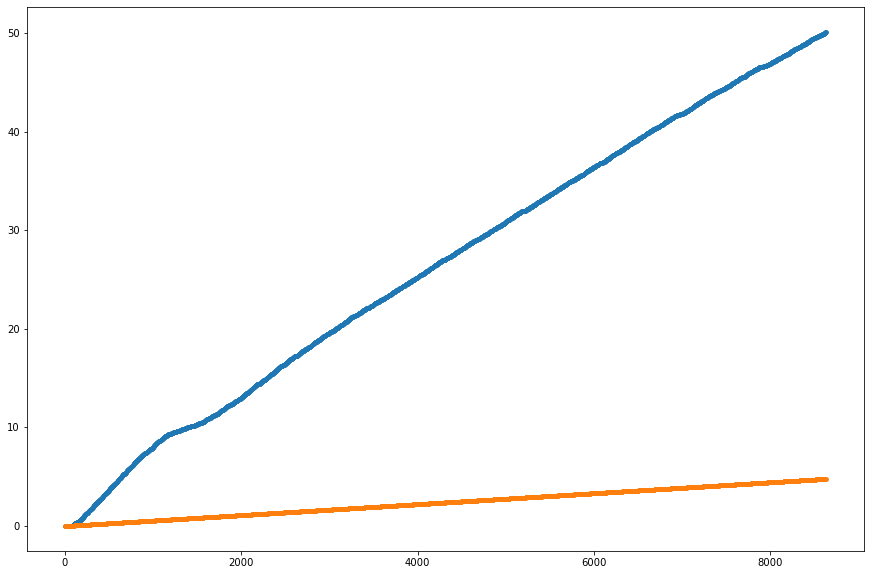

In [9]:
# check if force data has any problem 
i = 21
# fig, ax = plt.subplots(1,5,figsize=(15,1.5))
fig, ax = plt.subplots(figsize=(15,10))
for trial in range(3,4): #only read the 2_3 (third trial)
#     print(trial)
#     print(force_name)
    gt_force = read_force(str(i)+'/data_'+str(i)+'_'+str(trial)+'.csv',fc)
#     print('finish reading trial '+str(trial))
#         plt.ylim([-20,200])
    ax.plot(range(len(gt_force[force_start:force_end])),gt_force[force_start:force_end],'.',label = 'force ground truth')
print(type(gt_force))

x = [force_start,force_end]
x_new = np.arange(0,len(gt_force))
y = [0,est_dist]

x_new = 100

y_new = np.interp(x_new, x, y)
dist_interp = interp.interp1d(np.arange(len(y)),y)
dist_stretch = dist_interp(np.linspace(0,len(y)-1,force_end - force_start))
print(type(dist_stretch))
# 13.0

ax.plot(range(len(dist_stretch)),dist_stretch,'.',label = 'displacement ground truth')
ax.plot(range(len(X[str(i)+'_trial'][force_start:force_end])),0.035*X[str(i)+'_trial'][force_start:force_end],label = 'integrated velocity')
plt.legend(loc="upper left")
# gt_deformation = range(0,est_dist)
plt.show()

In [53]:
# write into csv
df = pd.DataFrame()
# the index is frame, automatically
# the first column is force, which is interpolated force data
df.loc[:,'force_ground_truth'] = pd.Series(gt_force[force_start:force_end])
# the second column is estimated distance, which is integration of velocity
df.loc[:,'integrated_velocity'] = pd.Series(X['1_trial'][force_start:force_end])   
# the third column is the true distance, which can be calculated. 
# by displacement per second * the time to reach the force peak
df.loc[:,'deformation_displacement_ground_truth'] = pd.Series(dist_stretch) 

df_filename = './output/figures/sensing_validation.csv'
df.to_csv(df_filename,sep='\t') 

In [30]:
anchor_0N = find_target_point(gt_force,0.2)-100
anchor_1N = find_target_point(gt_force,1)
anchor_2N = find_target_point(gt_force,2)
anchor_3N = find_target_point(gt_force,3)
anchor_4N = find_target_point(gt_force,4)
anchor_5N = find_target_point(gt_force,5)
print(anchor_0N)
print(anchor_1N)
print(anchor_2N)
print(anchor_3N)
print(anchor_4N)
print(anchor_5N)

937
1796
2735
3796
4579
5434


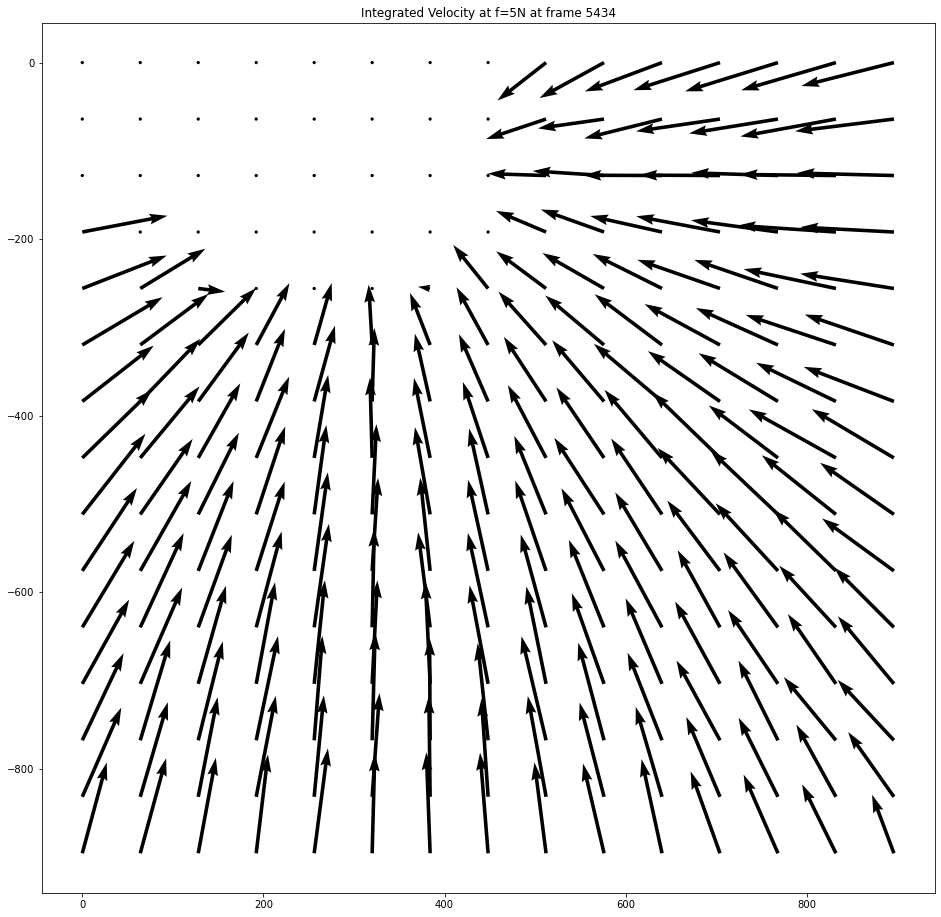

In [66]:
# plot the quiver
yy = np.arange(0,1536,64)
xx = np.arange(0,2048,64)
flow_sparse = flow[:,::16,::16,:]
flow_cum = np.cumsum(flow_sparse, axis = 0)
# x_list = flow_cum[:,;,:,0]
# y_list = flow_cum[:,;,:,1]
# print(flow)
k = anchor_5N
win = 1
scale = 1
x_data = scale*np.mean(flow_cum[k:k+win,:,:,0],axis = 0)
#     print(x_data[9:24].shape)
y_data = scale*np.mean(flow_cum[k:k+win,:,:,1],axis = 0)

fig, (ax) = plt.subplots(figsize =(16, 16)) 
ax.quiver(xx[0:15],-yy[0:15], x_data[7:22,12:27], -y_data[7:22,12:27],scale=2000)
ax.set_title('Integrated Velocity at f='+str(5)+'N'+' at frame '+str(k))
plt.savefig('5N.svg')
flow_avg = np.mean(flow_cum[k:k+win,:,:,:],axis = 0)
draw_flow(flow_avg,yy,xx)

In [ ]:
# check integration
fig, ax = plt.subplots(1,5,figsize=(15,1.5))
for trial in range(1,2): #only read the 2_3 (third trial)
#     print(trial)
#     print(force_name)
    integration = X[str(trial)+'_trial']
#     print('finish reading trial '+str(trial))
#         plt.ylim([-20,200])
    ax[trial-1].plot(range(len(integration)),integration,".")
plt.show()

In [ ]:
# fig1, ax = plt.subplots(1,1)
#Set plot size
j = 1
print(num_area)
a = 40

for p in range(200,300,10):
    for q in range(100,290,10):
        b = (p,q)
        print(b)
# b = (320,270)
        velocities_t = velocities_dict[str(j)+'_trial']#[:,b[1]-a:b[1]+a,b[0]-a:b[0]+a]
        gt_force_t = gt_force_dict[str(j)+'_trial']
        mean_velocity = np.sum(velocities_t, axis=(1,2))/num_area
        # plt.ylim([-0.5,1.2])
        # ax.set_title('Velocity over time '+str(trial))
        # ax.set_xlabel('frames')
        # ax.set_ylabel('Velocity')
        # ax.plot(range(len(mean_velocity)),mean_velocity,"*")
        # integration
        est_force = np.cumsum(mean_velocity)
        fig, ax = plt.subplots()
        #Set plot size
        fig.set_size_inches(7, 5)
#         plt.ylim([-20,200])
        ax.set_title('Estimated force over time')
        ax.set_xlabel('frames')
        ax.set_ylabel('Estimated force')
        ax.plot(range(len(est_force)),est_force,"*")
        plt.show()

In [ ]:
# integration
est_force = np.cumsum(mean_velocity)
fig1, ax1 = plt.subplots()
#Set plot size
fig1.set_size_inches(7, 5)
# plt.ylim([-20,200])
ax1.set_title('Estimated force over time')
ax1.set_xlabel('frames')
ax1.set_ylabel('Estimated force')
plt.plot(range(len(est_force)),est_force,"*")

In [ ]:
# force ground truth
j=1
fig2, ax2 = plt.subplots()
#Set plot size
fig2.set_size_inches(7, 5)
# plt.ylim([-0.5,1.2])
ax2.set_title('Ground truth force over time')
ax2.set_xlabel('frames')
ax2.set_ylabel('Ground truth force')
force_end = find_ending_point(gt_force_dict[str(j)+'_trial'],gt_force_dict[str(j)+'_trial'])
print(force_end)
force_start = find_starting_point(gt_force_dict[str(j)+'_trial'])
print(force_start)
plt.plot(range(len(gt_force_dict[str(j)+'_trial'])),gt_force_dict[str(j)+'_trial'],"*")

In [ ]:
# test panda dataframe
df = pd.DataFrame(columns=['a','b','c','d'])
row = pd.Series([5,6])
df.append(row, ignore_index=True)

In [ ]:
# test bin stats
bin_edges=np.arange(0, 5.5 ,0.5)
# error_bins, _, _ = stats.binned_statistic(Y_test, error, statistic='median', bins=bin_edges)
print(bin_edges)
print(bin_edges.shape)

# full frame over train-test split percentage (calibration 1)

### only for incidence angles supp studies

In [10]:
def integration_incidence_angles_split(ExpNo, X, Y):
    
    df = pd.DataFrame(index=range(30))
    for n_train in range(1,3):
        comb = combinations(range(1,4), n_train)
        comb =[i for i in comb]
        error_values_test = np.zeros((len(comb),3-n_train))
        r2s_test = np.zeros((len(comb),3-n_train))
        for j in range(0,len(comb)):# the j-th combination of n_train trials
            # data preparation
            for k in range(n_train): # the k-th trial in the j-th combination
                idx = comb[j][k]
                force_start = find_starting_point(Y[str(idx)+'_trial'])
                force_start = max(0,force_start-50)
                print('force_start',force_start)
                if k == 0:  
                    Y_train = Y[str(idx)+'_trial'][force_start:]
                    X_train = X[str(idx)+'_trial'][force_start:]
                else:
                    Y_train_new = Y[str(idx)+'_trial'][force_start:]
                    X_train_new = X[str(idx)+'_trial'][force_start:]
                    Y_train = np.concatenate((Y_train, Y_train_new), axis=0)
                    X_train = np.concatenate((X_train, X_train_new), axis=0)
            # train
            Regressor = np.poly1d(np.polyfit(X_train, Y_train, 1))
            Y_pred_train = Regressor(X_train)
            print(Regressor)
            
            # test
            counter = 0
            for test in range(1,4):
                if test in comb[j]:
                    continue
                # test
                force_start = find_starting_point(Y[str(test)+'_trial'])
                force_start = max(0,force_start-50)
                X_test = X[str(test)+'_trial'][force_start:]
                Y_test = Y[str(test)+'_trial'][force_start:]
                Y_pred_test = Regressor(X_test)  # make predictions

    #             error = abs(Y_pred_test-Y_test)/Y_test
                error_value = abs(Y_pred_test-Y_test)
                error_value_avg = np.mean(error_value)
                error_values_test[j][counter] = error_value_avg
                r2s_test[j][counter] = r2_score(Y_test, Y_pred_test)
                print('==============='+str(counter)+'===============')
                print('train on '+str(n_train)+' combination: '+str(comb[j])+' and test on '+str(test))
                
                fig, ax = plt.subplots(2,1,figsize = (7,10))
                ax[0].scatter(Y_test, X_test, color='blue')
                ax[0].scatter(Y_train, X_train, color='green')
                ax[0].plot(Y_pred_test,X_test, color='red')
    #             ax[0].set_xlim([0,5])
                ax[1].plot(Y_test,error_value, color='green')
                ax[1].set_title('Estimation error over force')
                ax[1].set_xlabel('Force(N)')
                ax[1].set_ylabel('Error(N)')
                ax[1].set_ylim([0,5])
                plt.show()
                counter+=1
        error_values_test = error_values_test.reshape(-1)
        r2s_test = r2s_test.reshape(-1)
        df.loc[:,'err_'+str(n_train)] = pd.Series(error_values_test)
        df.loc[:,'r2_'+str(n_train)] = pd.Series(r2s_test)   
    df_filename = './output/cache/cali_1_No_'+str(ExpNo)+'_split.pkl'
    df.to_pickle(df_filename) 
    return df_filename

In [12]:
ExpNo = 21

In [13]:
df_filename = integration_incidence_angles_split(ExpNo, X, Y)

KeyError: '1_trial'

### only for supp studies - wide array of materials

force_start 358
(3122,) (3122,)
 
0.4581 x + 1.457
R2 0.9320765052243337


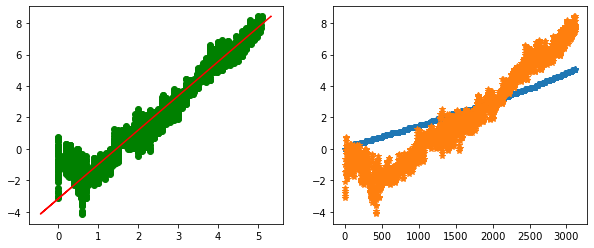

In [171]:
# train on one trial without test, for 36 - the wide array of materials

def integration_many_materials(X, Y, idx):
    
    force_start = find_starting_point(Y[str(idx)+'_trial'])
    force_start = max(0,force_start-50)
    print('force_start',force_start)

    Y_train = Y[str(idx)+'_trial'][force_start:]
    X_train = X[str(idx)+'_trial'][force_start:]
    print(X_train.shape,Y_train.shape)
    Regressor = np.poly1d(np.polyfit(X_train, Y_train, 1))
    Y_pred_train = Regressor(X_train)
    print(Regressor)
    r2 = r2_score(Y_train, Y_pred_train)
    print('R2',r2)
    
    fig, ax = plt.subplots(1,2,figsize = (10,4))
    ax[0].scatter(Y_train, X_train, color='green')
    ax[0].plot(Y_pred_train,X_train, color='red')
#             ax[0].set_xlim([0,5])
    ax[1].plot(range(len(Y_train)),Y_train,"*")
    ax[1].plot(range(len(X_train)),X_train,"*")
    plt.show()  

integration_many_materials(X,Y,3) #1,5,7 Not working

### for general use

In [172]:
###New function for gridding integration
def integration_linear_split(ExpNo, X, Y):
    
    df = pd.DataFrame(index=range(30))
    for n_train in range(1,5):
        comb = combinations(range(1,6), n_train)
        comb =[i for i in comb]
        error_values_test = np.zeros((len(comb),5-n_train))
        r2s_test = np.zeros((len(comb),5-n_train))
        for j in range(0,len(comb)):# the j-th combination of n_train trials
            # data preparation
            for k in range(n_train): # the k-th trial in the j-th combination
                idx = comb[j][k]
                if (ExpNo==22 or ExpNo==23 or ExpNo==24 or ExpNo==25 or ExpNo == 26):
                    force_start = (np.abs(Y[str(idx)+'_trial'] - 0.2)).argmin()
                else:
                    force_start = find_starting_point(Y[str(idx)+'_trial'])
                    force_start = max(0,force_start-50)
                print('force_start',force_start)
                if k == 0:  
                    Y_train = Y[str(idx)+'_trial'][force_start:]
                    X_train = X[str(idx)+'_trial'][force_start:]
                else:
                    Y_train_new = Y[str(idx)+'_trial'][force_start:]
                    X_train_new = X[str(idx)+'_trial'][force_start:]
                    Y_train = np.concatenate((Y_train, Y_train_new), axis=0)
                    X_train = np.concatenate((X_train, X_train_new), axis=0)
            # train
            Regressor = np.poly1d(np.polyfit(X_train, Y_train, 1))
            Y_pred_train = Regressor(X_train)
            print(Regressor)
            
            # test
            counter = 0
            for test in range(1,6):
                if test in comb[j]:
                    continue
                # test
                if (ExpNo==22 or ExpNo==23 or ExpNo==24 or ExpNo==25 or ExpNo == 26):
                    force_start = (np.abs(Y[str(idx)+'_trial'] - 0.2)).argmin()
                else:
                    force_start = find_starting_point(Y[str(test)+'_trial'])
                    force_start = max(0,force_start-50)
                X_test = X[str(test)+'_trial'][force_start:]
                Y_test = Y[str(test)+'_trial'][force_start:]
                Y_pred_test = Regressor(X_test)  # make predictions

    #             error = abs(Y_pred_test-Y_test)/Y_test
                error_value = abs(Y_pred_test-Y_test)
                error_value_avg = np.mean(error_value)
                error_values_test[j][counter] = error_value_avg
                r2s_test[j][counter] = r2_score(Y_test, Y_pred_test)
                print('==============='+str(counter)+'===============')
                print('train on '+str(n_train)+' combination: '+str(comb[j])+' and test on '+str(test))
                
                fig, ax = plt.subplots(2,1,figsize = (7,10))
                ax[0].scatter(Y_test, X_test, color='blue')
                ax[0].scatter(Y_train, X_train, color='green')
                ax[0].plot(Y_pred_test,X_test, color='red')
    #             ax[0].set_xlim([0,5])
                ax[1].plot(Y_test,error_value, color='green')
                ax[1].set_title('Estimation error over force')
                ax[1].set_xlabel('Force(N)')
                ax[1].set_ylabel('Error(N)')
                ax[1].set_ylim([0,5])
                plt.show()
                counter+=1
        error_values_test = error_values_test.reshape(-1)
        r2s_test = r2s_test.reshape(-1)
        df.loc[:,'err_'+str(n_train)] = pd.Series(error_values_test)
        df.loc[:,'r2_'+str(n_train)] = pd.Series(r2s_test)   
    df_filename = './output/cache/cali_1_No_'+str(ExpNo)+'_split.pkl'
    df.to_pickle(df_filename) 
    return df_filename

force_start 1288
 
0.3386 x + 1.283
===============0===============
train on 1 combination: (1,) and test on 2


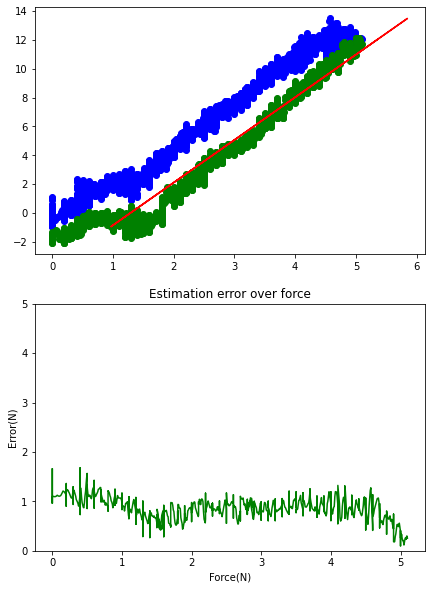

===============1===============
train on 1 combination: (1,) and test on 3


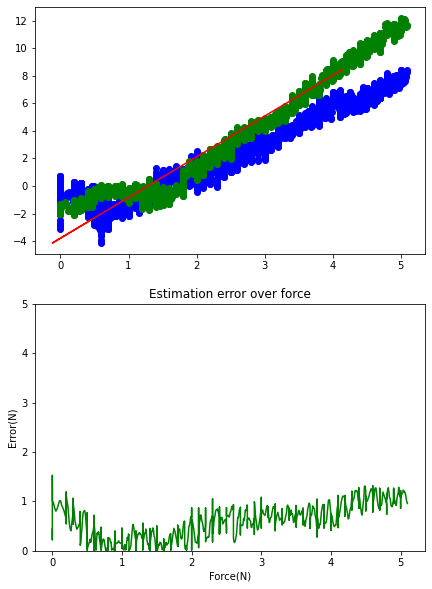

===============2===============
train on 1 combination: (1,) and test on 4


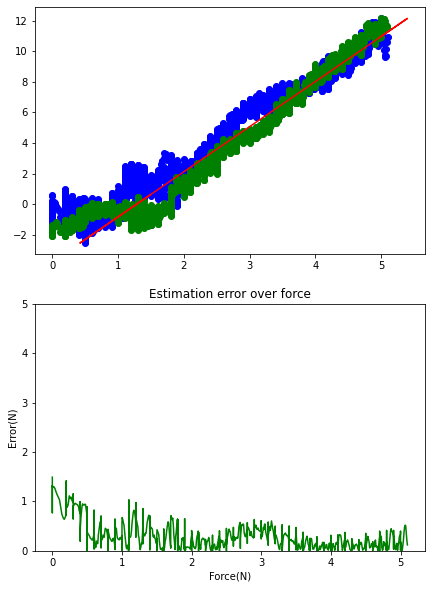

===============3===============
train on 1 combination: (1,) and test on 5


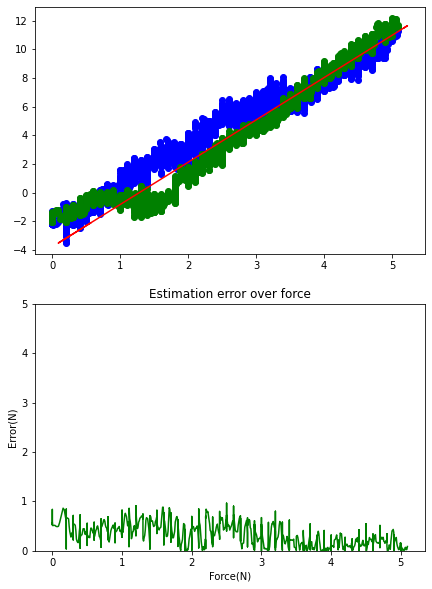

force_start 1102
 
0.3501 x + 0.3337
===============0===============
train on 1 combination: (2,) and test on 1


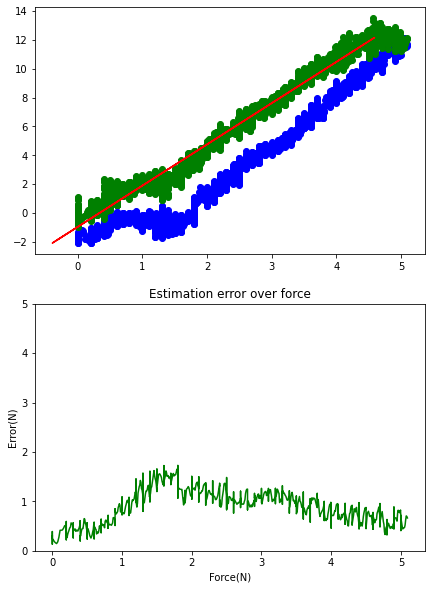

===============1===============
train on 1 combination: (2,) and test on 3


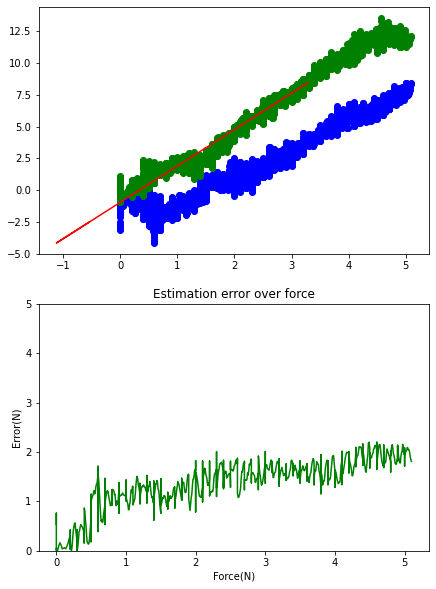

===============2===============
train on 1 combination: (2,) and test on 4


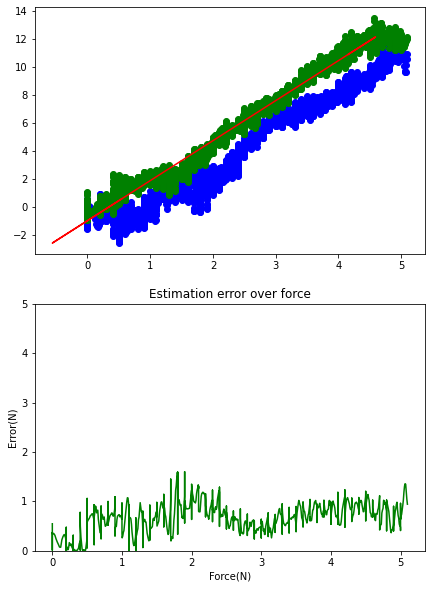

===============3===============
train on 1 combination: (2,) and test on 5


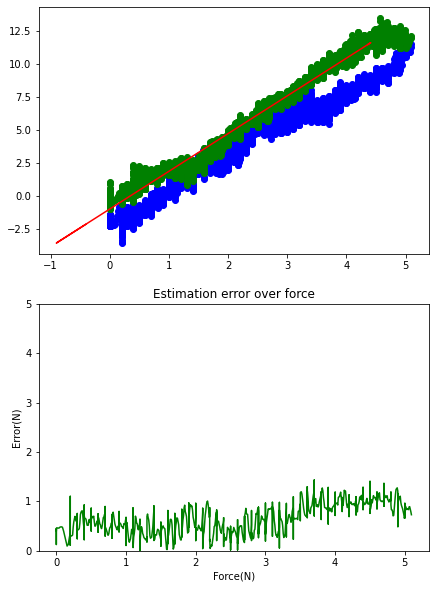

force_start 358
 
0.4581 x + 1.457
===============0===============
train on 1 combination: (3,) and test on 1


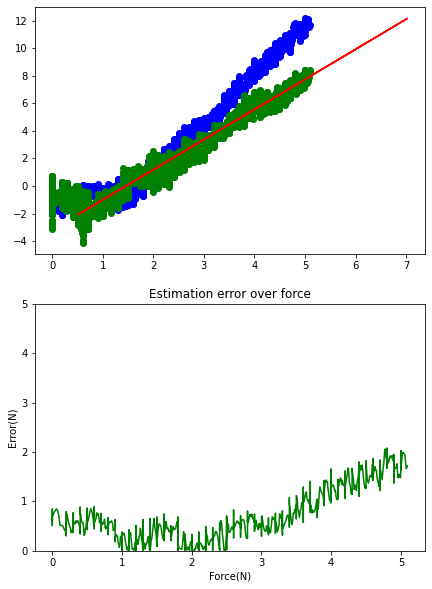

===============1===============
train on 1 combination: (3,) and test on 2


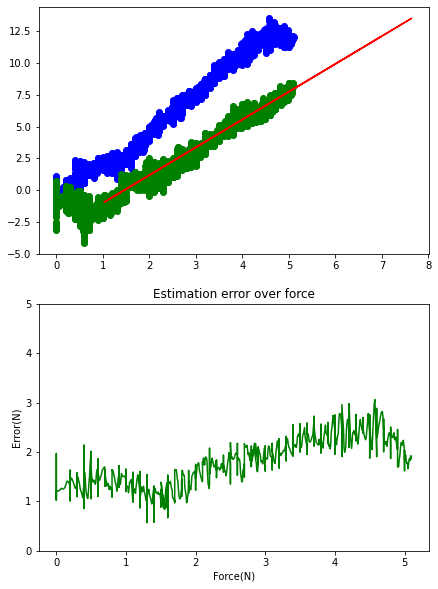

===============2===============
train on 1 combination: (3,) and test on 4


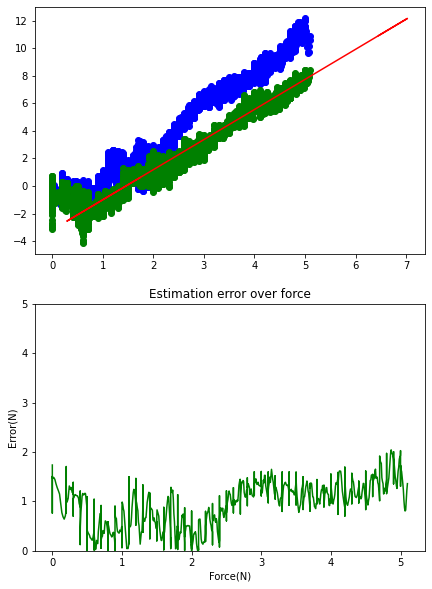

===============3===============
train on 1 combination: (3,) and test on 5


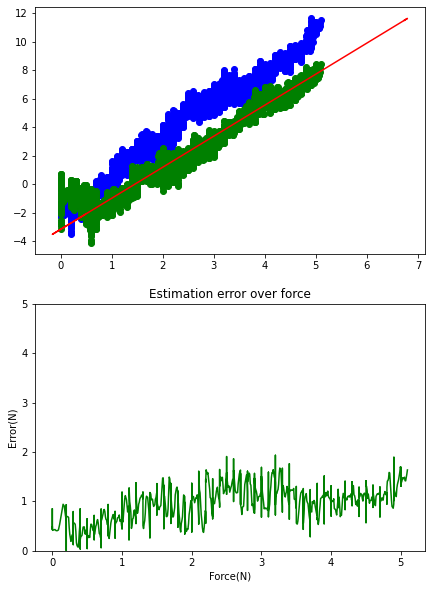

force_start 958
 
0.3703 x + 0.8976
===============0===============
train on 1 combination: (4,) and test on 1


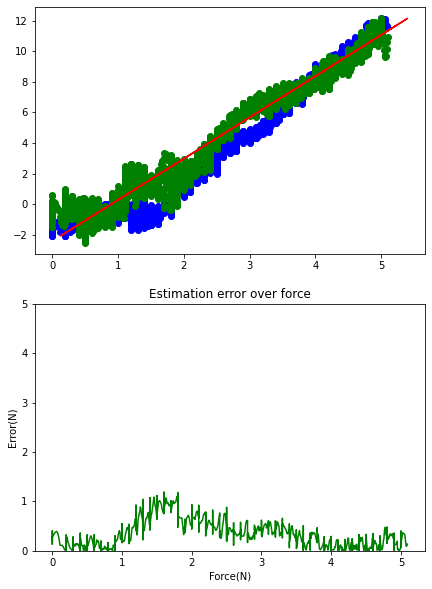

===============1===============
train on 1 combination: (4,) and test on 2


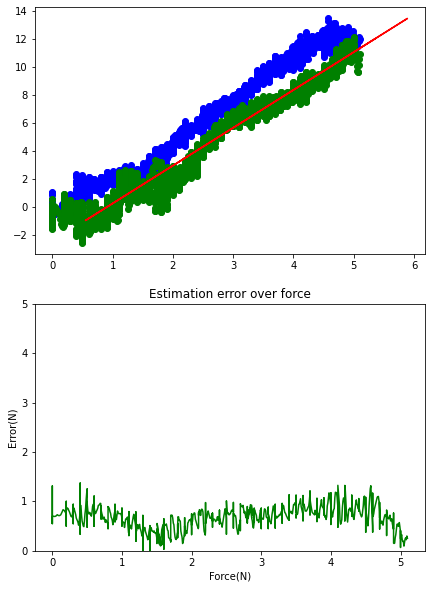

===============2===============
train on 1 combination: (4,) and test on 3


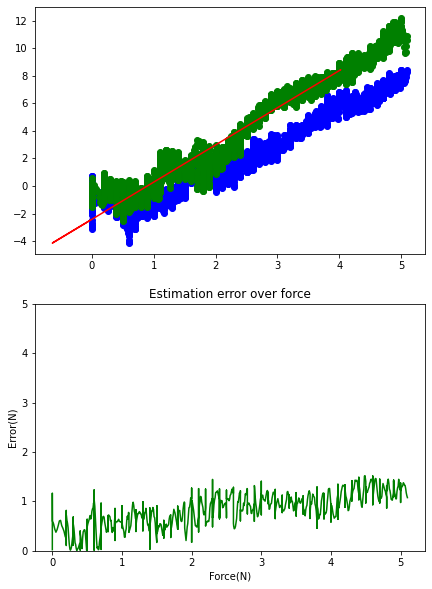

===============3===============
train on 1 combination: (4,) and test on 5


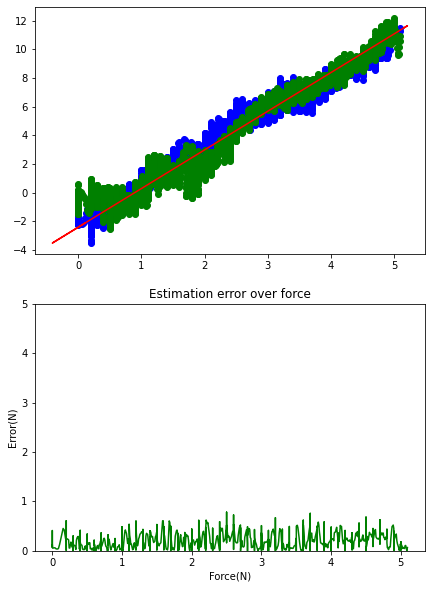

force_start 1071
 
0.3849 x + 0.808
===============0===============
train on 1 combination: (5,) and test on 1


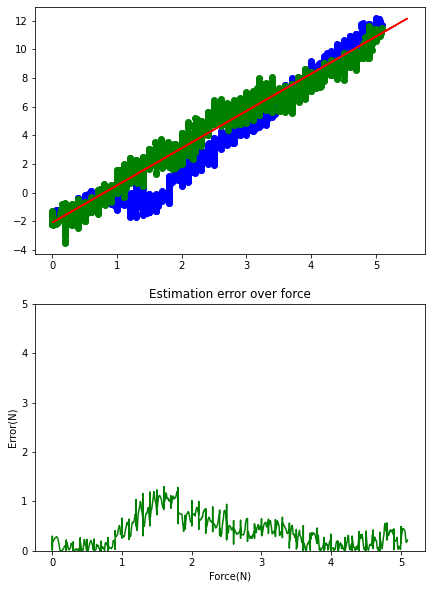

===============1===============
train on 1 combination: (5,) and test on 2


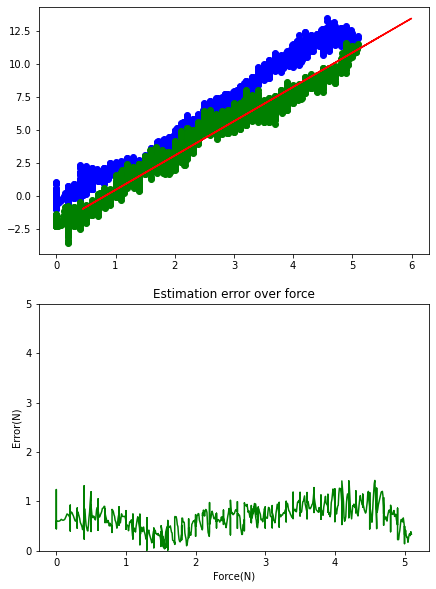

===============2===============
train on 1 combination: (5,) and test on 3


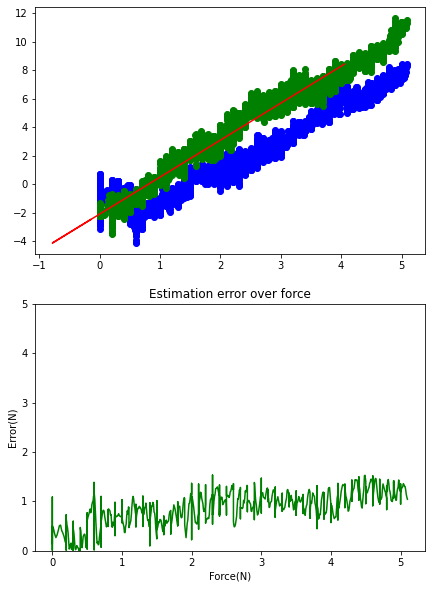

===============3===============
train on 1 combination: (5,) and test on 4


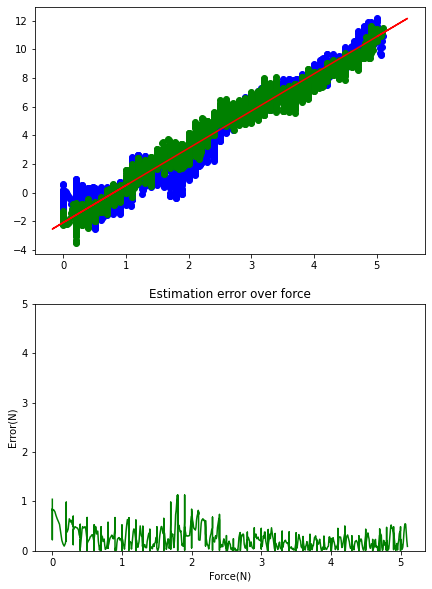

force_start 1288
force_start 1102
 
0.312 x + 0.9718
===============0===============
train on 2 combination: (1, 2) and test on 3


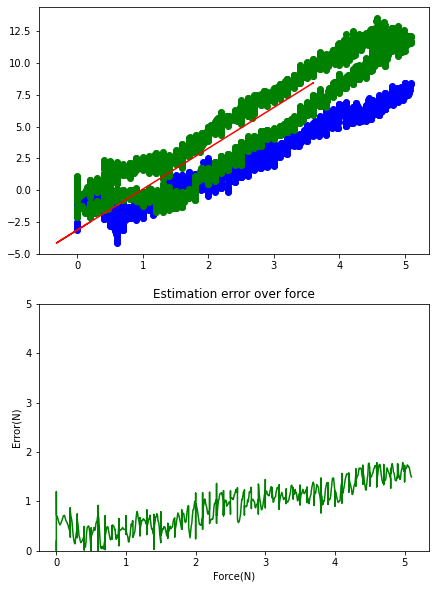

===============1===============
train on 2 combination: (1, 2) and test on 4


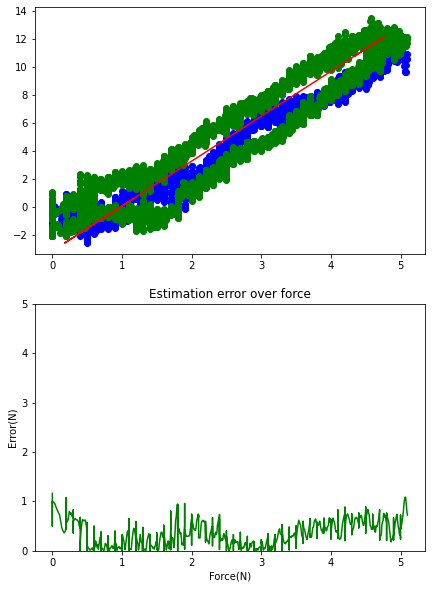

===============2===============
train on 2 combination: (1, 2) and test on 5


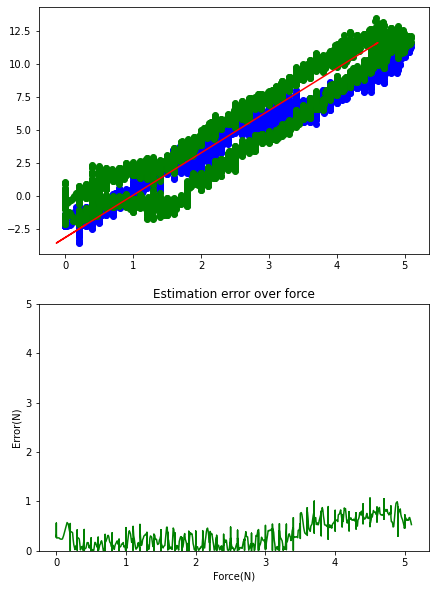

force_start 1288
force_start 358
 
0.369 x + 1.408
===============0===============
train on 2 combination: (1, 3) and test on 2


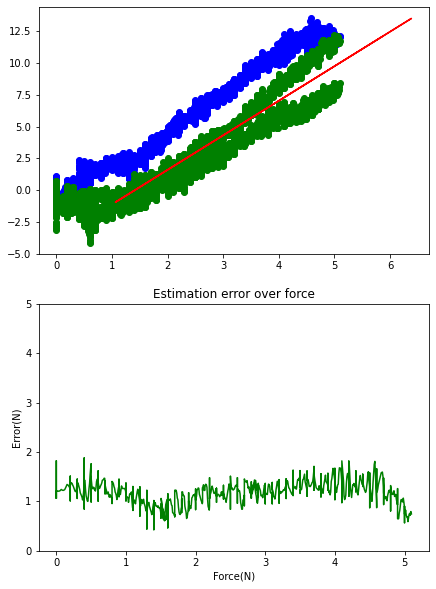

===============1===============
train on 2 combination: (1, 3) and test on 4


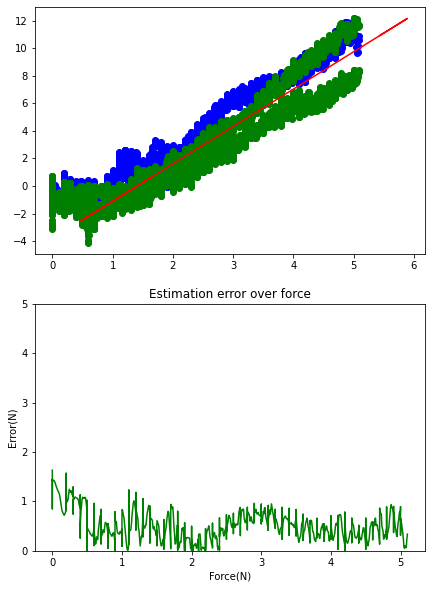

===============2===============
train on 2 combination: (1, 3) and test on 5


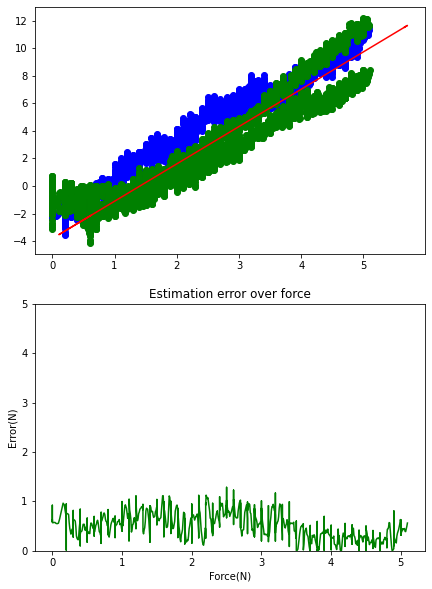

force_start 1288
force_start 958
 
0.3505 x + 1.11
===============0===============
train on 2 combination: (1, 4) and test on 2


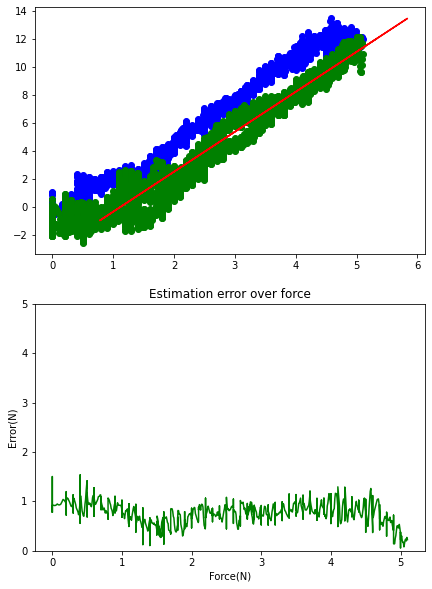

===============1===============
train on 2 combination: (1, 4) and test on 3


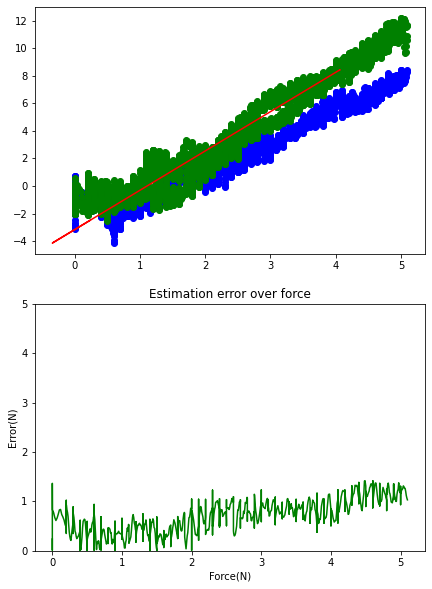

===============2===============
train on 2 combination: (1, 4) and test on 5


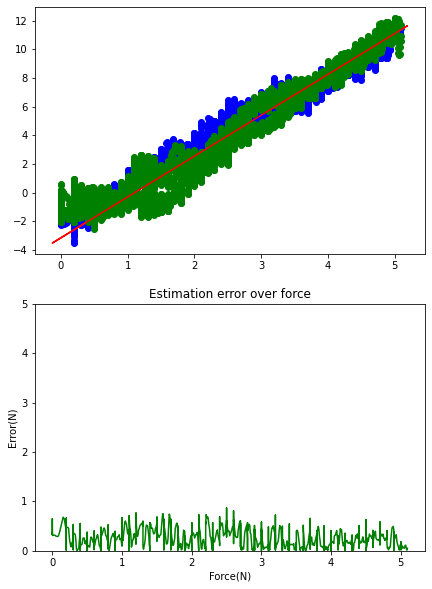

force_start 1288
force_start 1071
 
0.3558 x + 1.075
===============0===============
train on 2 combination: (1, 5) and test on 2


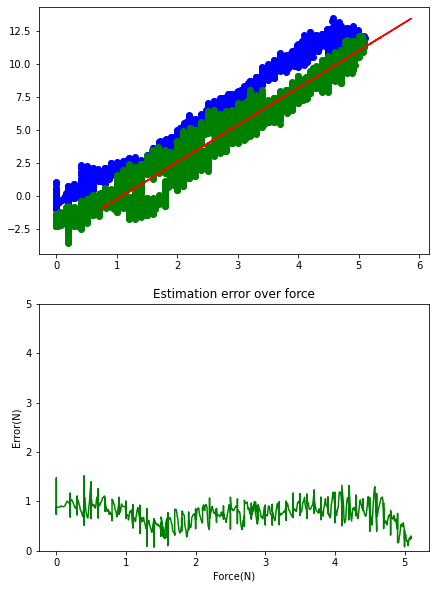

===============1===============
train on 2 combination: (1, 5) and test on 3


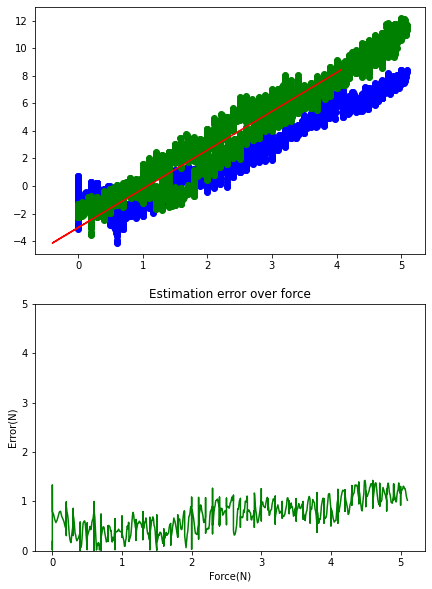

===============2===============
train on 2 combination: (1, 5) and test on 4


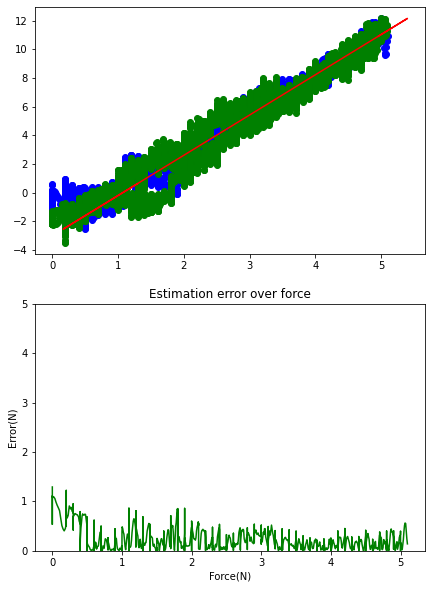

force_start 1102
force_start 358
 
0.2998 x + 1.211
===============0===============
train on 2 combination: (2, 3) and test on 1


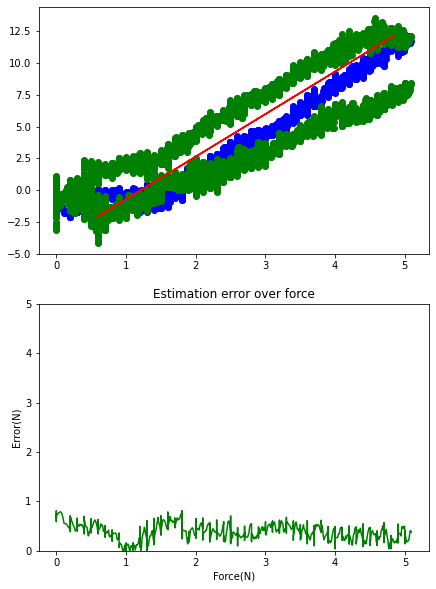

===============1===============
train on 2 combination: (2, 3) and test on 4


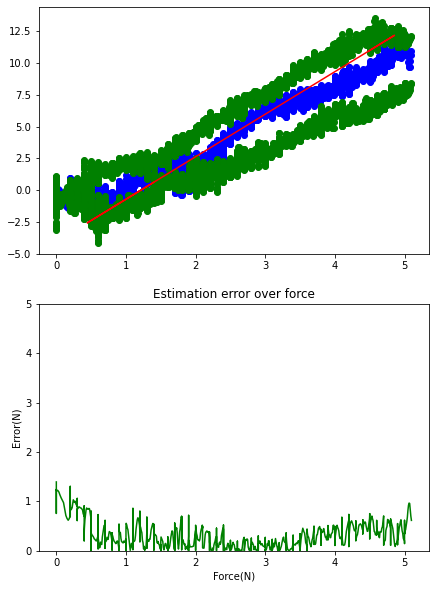

===============2===============
train on 2 combination: (2, 3) and test on 5


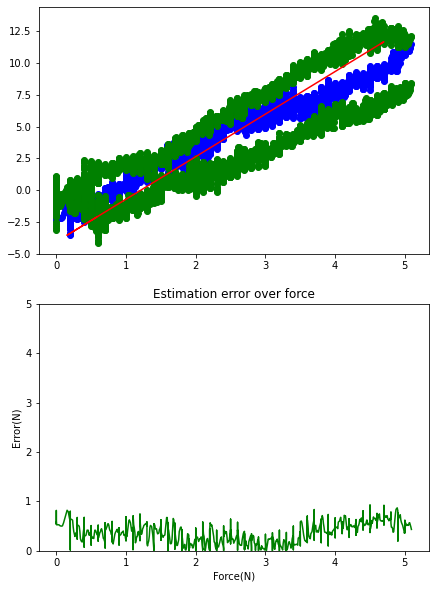

force_start 1102
force_start 958
 
0.3384 x + 0.7172
===============0===============
train on 2 combination: (2, 4) and test on 1


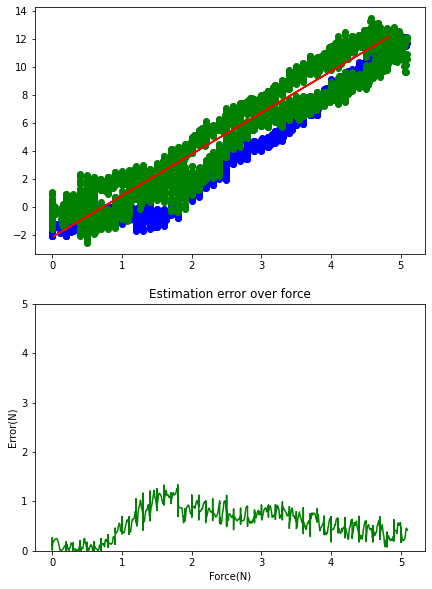

===============1===============
train on 2 combination: (2, 4) and test on 3


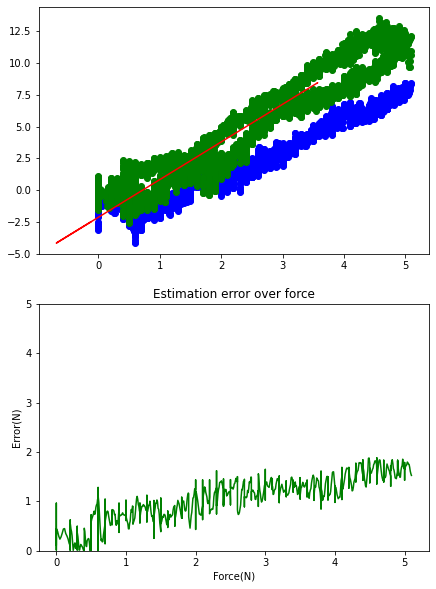

===============2===============
train on 2 combination: (2, 4) and test on 5


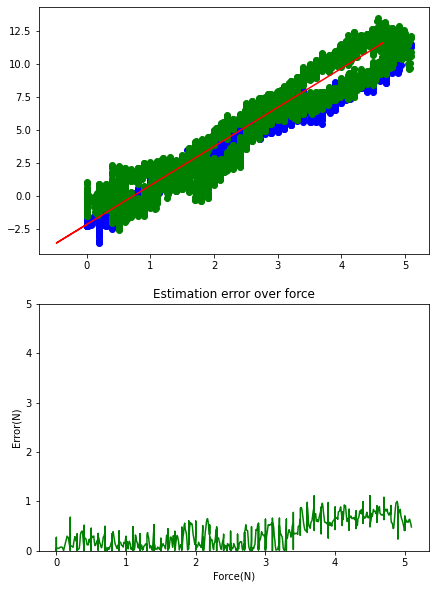

force_start 1102
force_start 1071
 
0.3443 x + 0.671
===============0===============
train on 2 combination: (2, 5) and test on 1


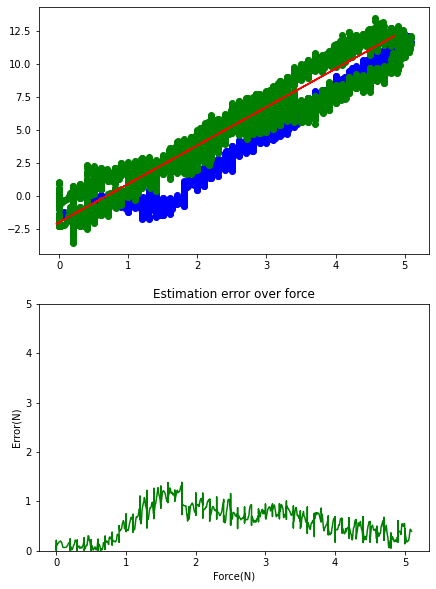

===============1===============
train on 2 combination: (2, 5) and test on 3


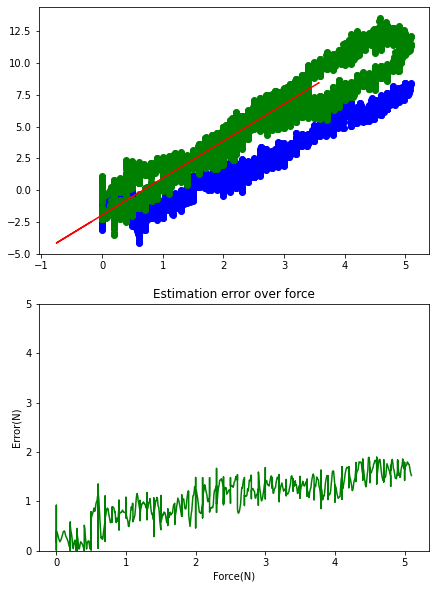

===============2===============
train on 2 combination: (2, 5) and test on 4


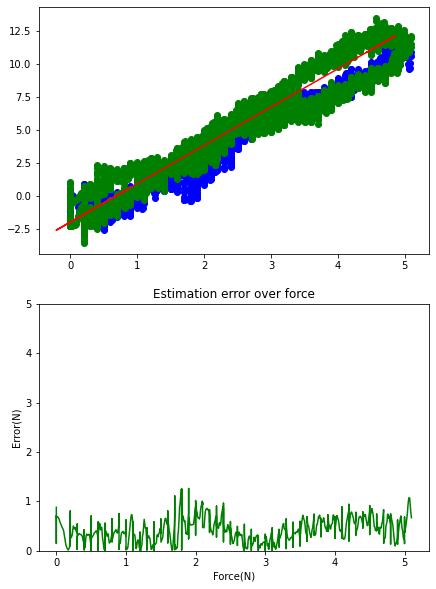

force_start 358
force_start 958
 
0.3735 x + 1.255
===============0===============
train on 2 combination: (3, 4) and test on 1


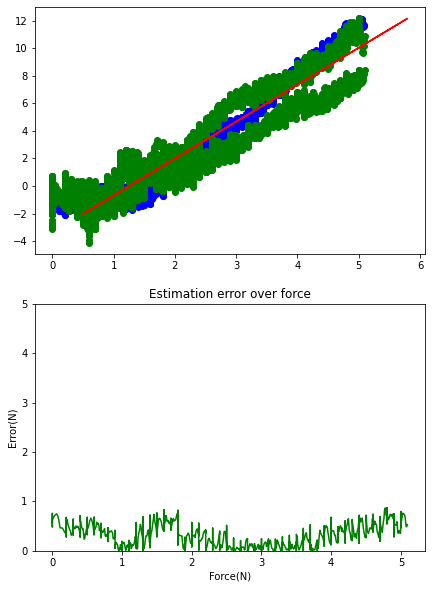

===============1===============
train on 2 combination: (3, 4) and test on 2


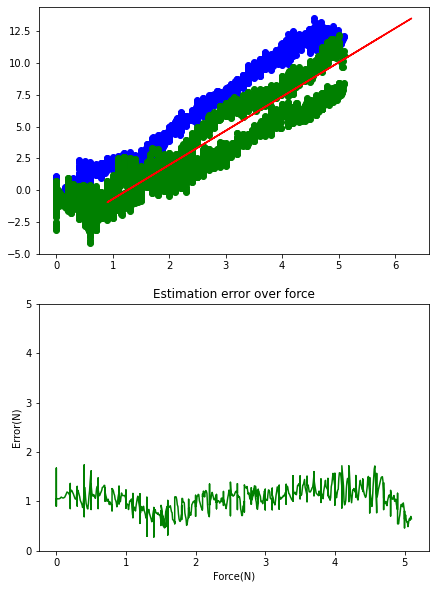

===============2===============
train on 2 combination: (3, 4) and test on 5


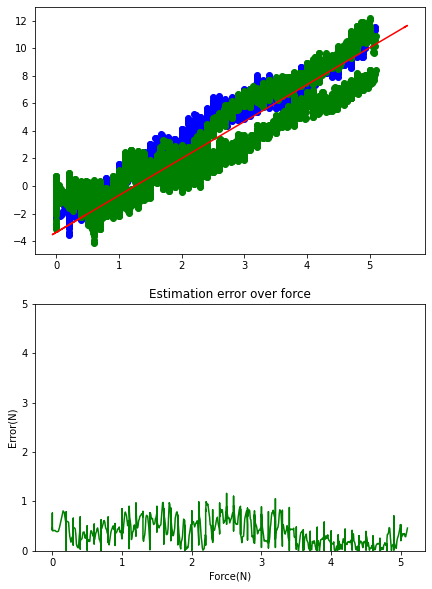

force_start 358
force_start 1071
 
0.3803 x + 1.22
===============0===============
train on 2 combination: (3, 5) and test on 1


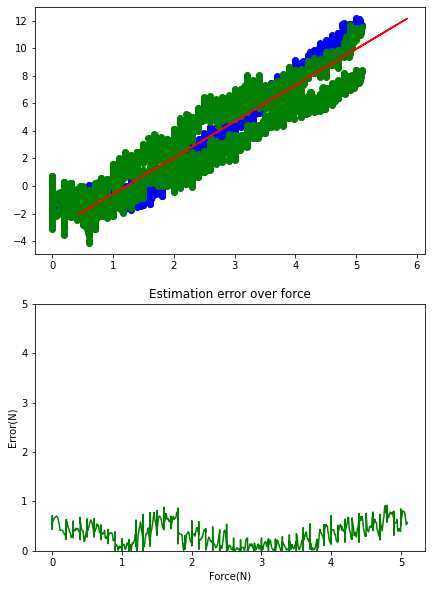

===============1===============
train on 2 combination: (3, 5) and test on 2


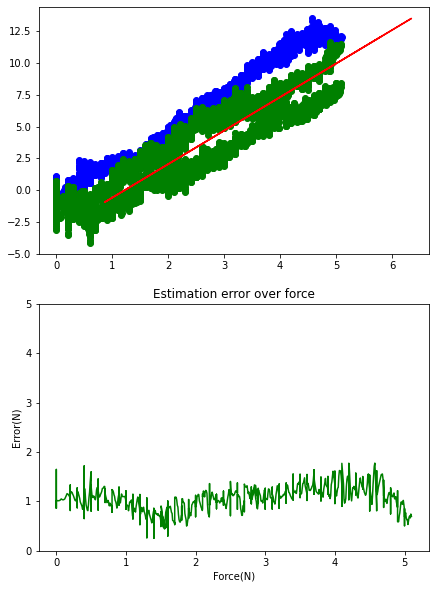

===============2===============
train on 2 combination: (3, 5) and test on 4


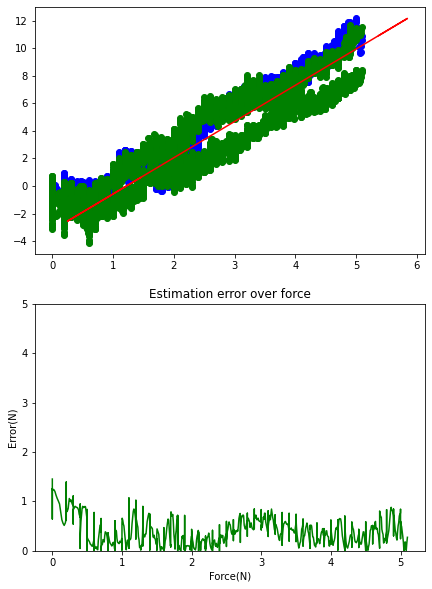

force_start 958
force_start 1071
 
0.3773 x + 0.854
===============0===============
train on 2 combination: (4, 5) and test on 1


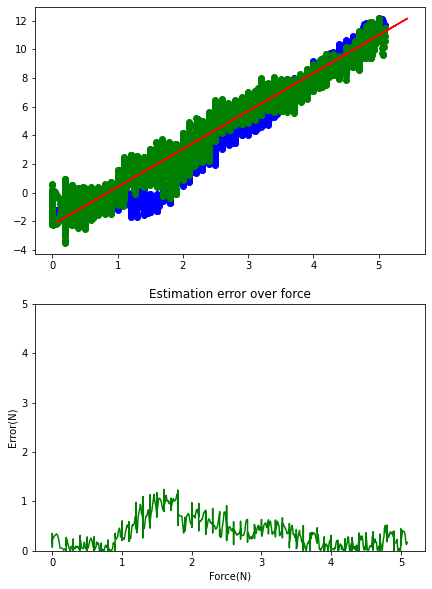

===============1===============
train on 2 combination: (4, 5) and test on 2


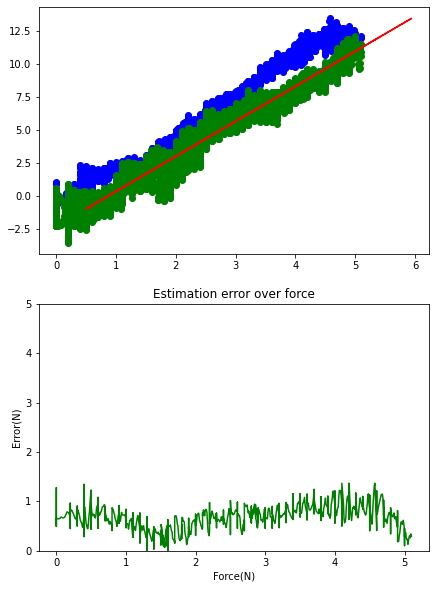

===============2===============
train on 2 combination: (4, 5) and test on 3


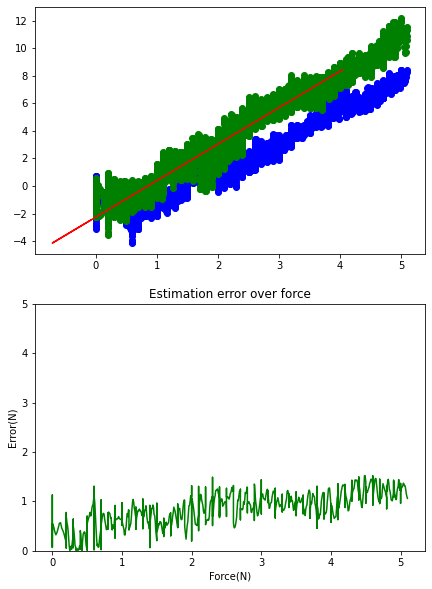

force_start 1288
force_start 1102
force_start 358
 
0.3109 x + 1.237
===============0===============
train on 3 combination: (1, 2, 3) and test on 4


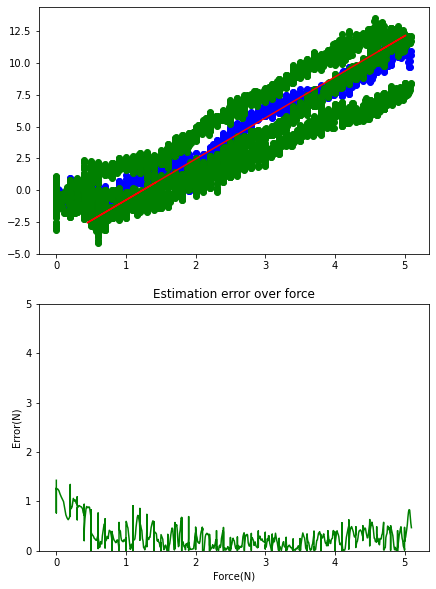

===============1===============
train on 3 combination: (1, 2, 3) and test on 5


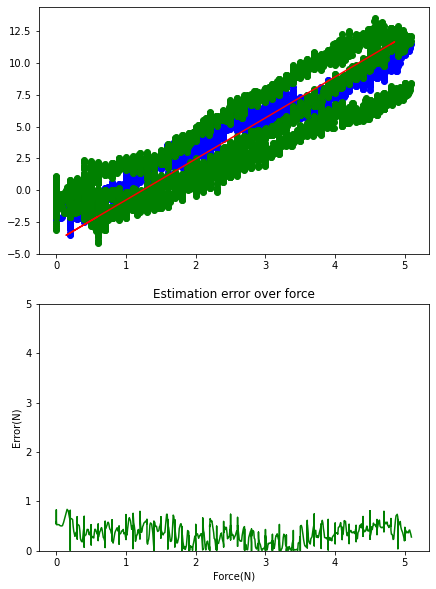

force_start 1288
force_start 1102
force_start 958
 
0.3264 x + 0.9604
===============0===============
train on 3 combination: (1, 2, 4) and test on 3


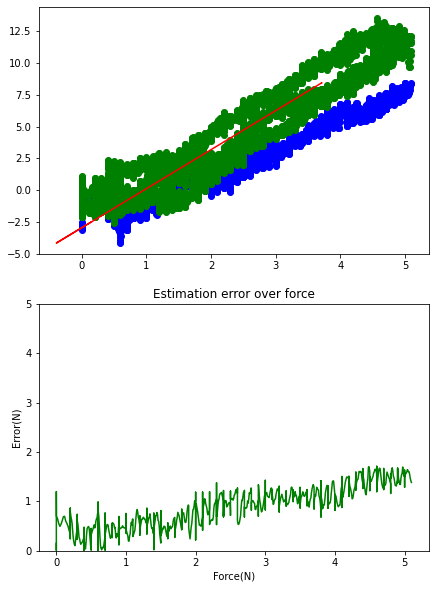

===============1===============
train on 3 combination: (1, 2, 4) and test on 5


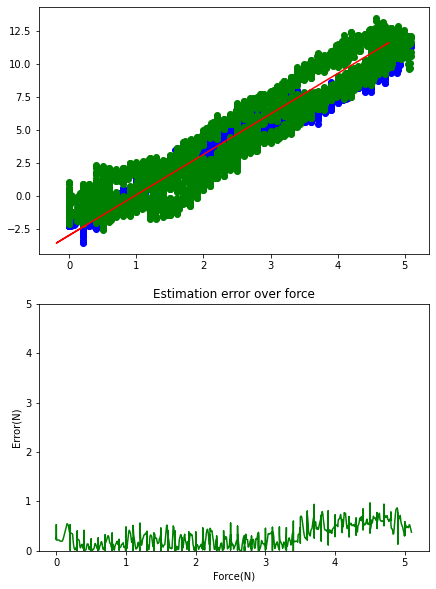

force_start 1288
force_start 1102
force_start 1071
 
0.3295 x + 0.9357
===============0===============
train on 3 combination: (1, 2, 5) and test on 3


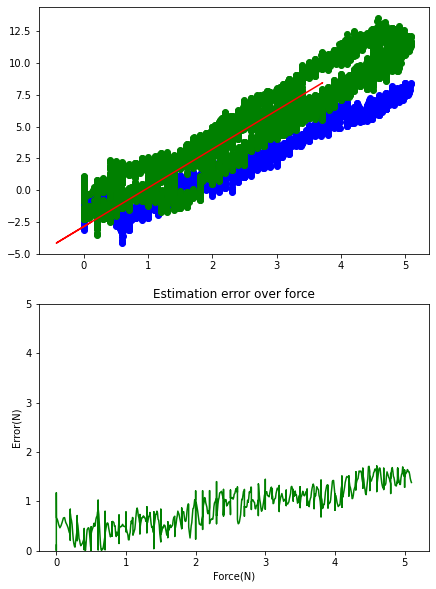

===============1===============
train on 3 combination: (1, 2, 5) and test on 4


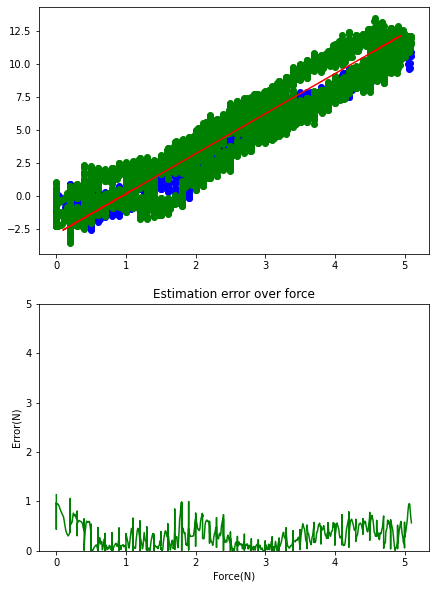

force_start 1288
force_start 358
force_start 958
 
0.359 x + 1.27
===============0===============
train on 3 combination: (1, 3, 4) and test on 2


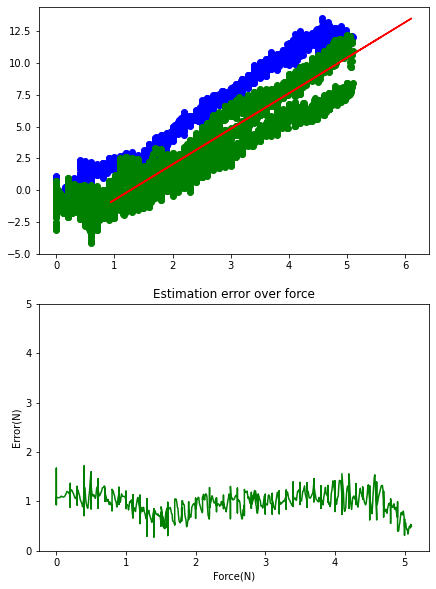

===============1===============
train on 3 combination: (1, 3, 4) and test on 5


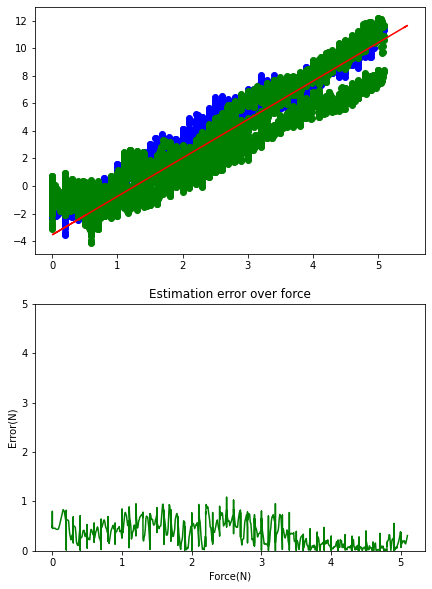

force_start 1288
force_start 358
force_start 1071
 
0.3628 x + 1.249
===============0===============
train on 3 combination: (1, 3, 5) and test on 2


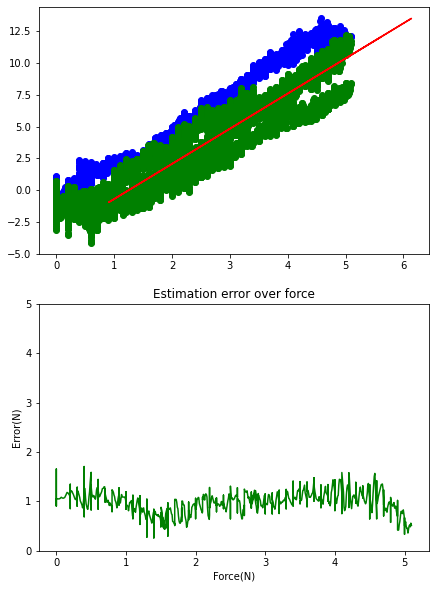

===============1===============
train on 3 combination: (1, 3, 5) and test on 4


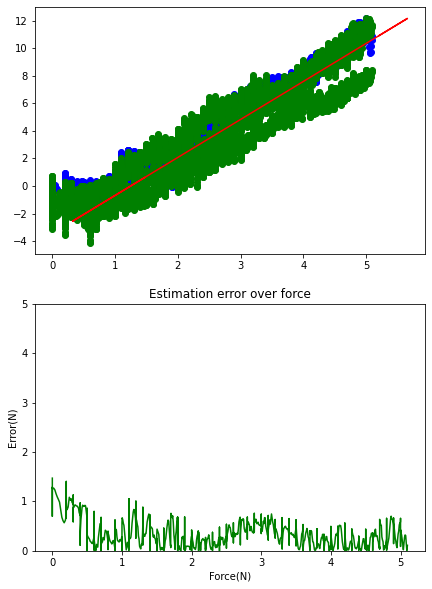

force_start 1288
force_start 958
force_start 1071
 
0.3599 x + 1.019
===============0===============
train on 3 combination: (1, 4, 5) and test on 2


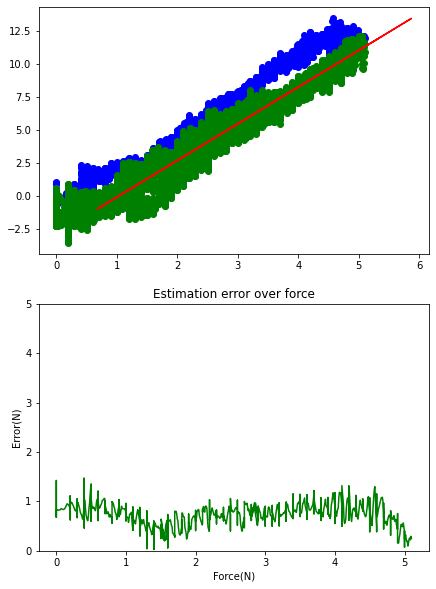

===============1===============
train on 3 combination: (1, 4, 5) and test on 3


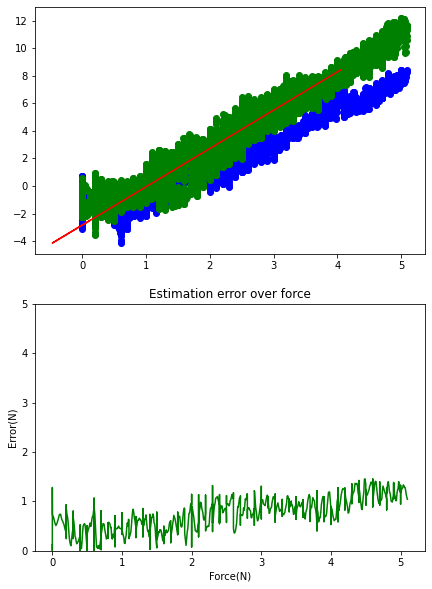

force_start 1102
force_start 358
force_start 958
 
0.3204 x + 1.117
===============0===============
train on 3 combination: (2, 3, 4) and test on 1


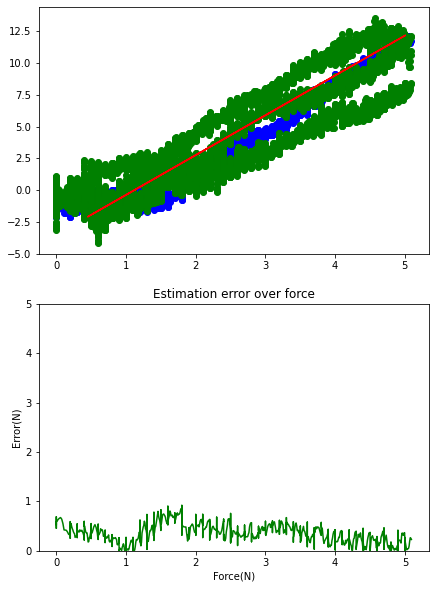

===============1===============
train on 3 combination: (2, 3, 4) and test on 5


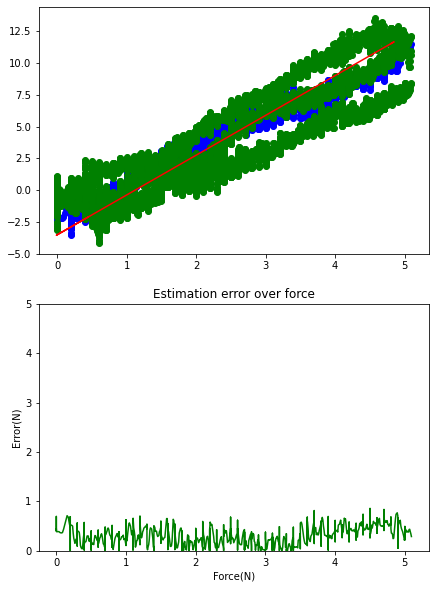

force_start 1102
force_start 358
force_start 1071
 
0.3233 x + 1.095
===============0===============
train on 3 combination: (2, 3, 5) and test on 1


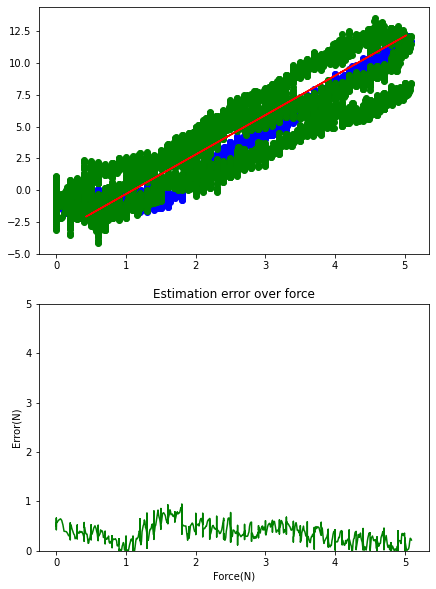

===============1===============
train on 3 combination: (2, 3, 5) and test on 4


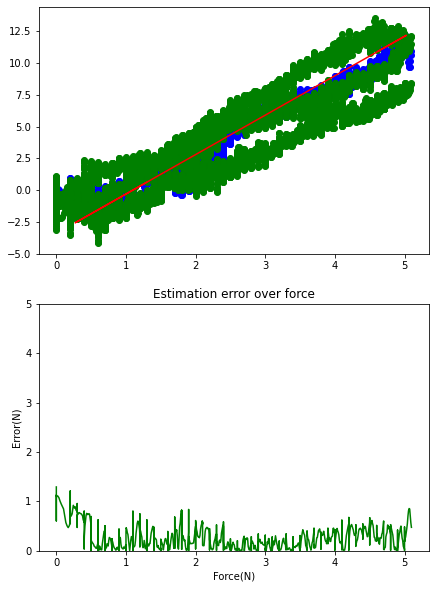

force_start 1102
force_start 958
force_start 1071
 
0.3472 x + 0.7682
===============0===============
train on 3 combination: (2, 4, 5) and test on 1


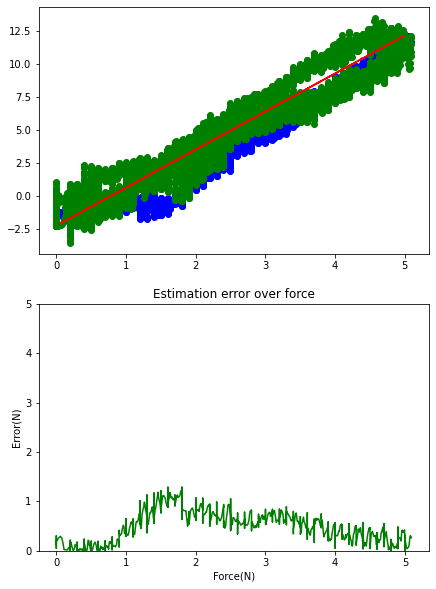

===============1===============
train on 3 combination: (2, 4, 5) and test on 3


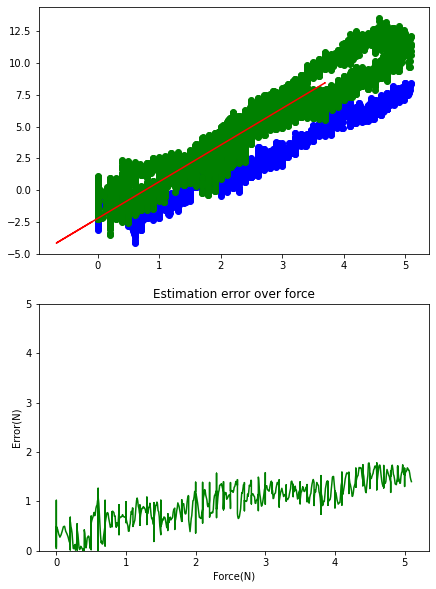

force_start 358
force_start 958
force_start 1071
 
0.3705 x + 1.131
===============0===============
train on 3 combination: (3, 4, 5) and test on 1


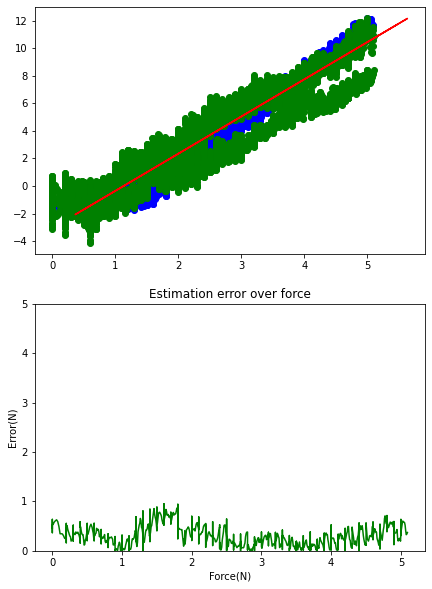

===============1===============
train on 3 combination: (3, 4, 5) and test on 2


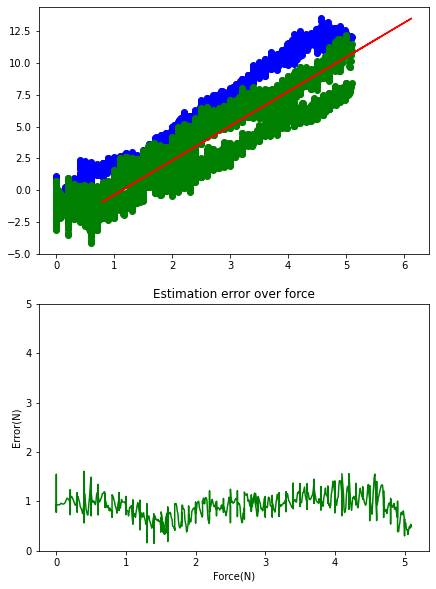

force_start 1288
force_start 1102
force_start 358
force_start 958
 
0.3235 x + 1.163
===============0===============
train on 4 combination: (1, 2, 3, 4) and test on 5


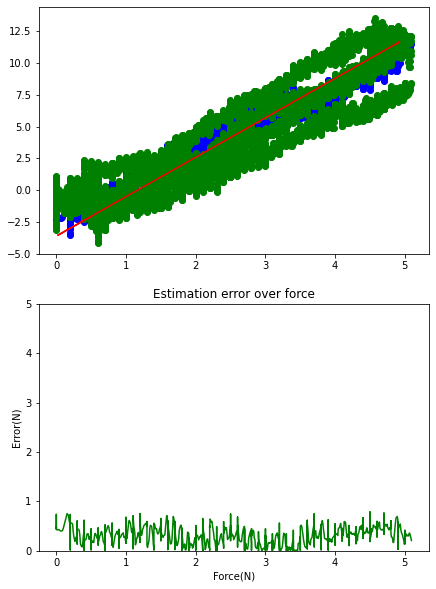

force_start 1288
force_start 1102
force_start 358
force_start 1071
 
0.3255 x + 1.147
===============0===============
train on 4 combination: (1, 2, 3, 5) and test on 4


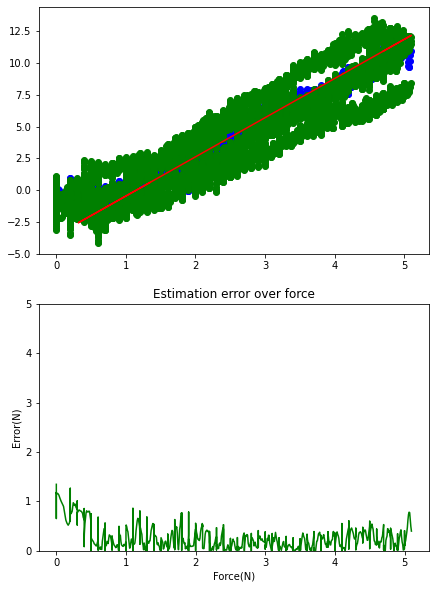

force_start 1288
force_start 1102
force_start 958
force_start 1071
 
0.3377 x + 0.9315
===============0===============
train on 4 combination: (1, 2, 4, 5) and test on 3


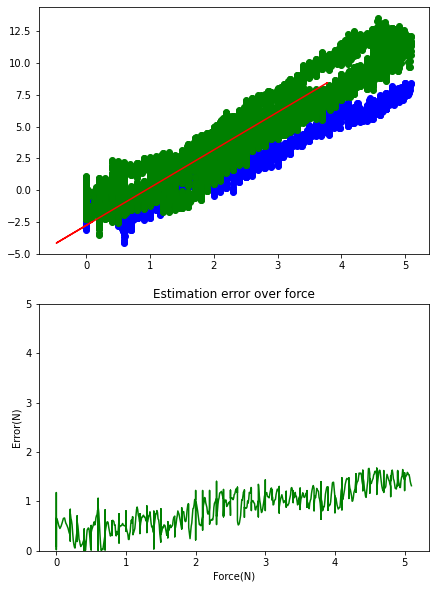

force_start 1288
force_start 358
force_start 958
force_start 1071
 
0.3609 x + 1.174
===============0===============
train on 4 combination: (1, 3, 4, 5) and test on 2


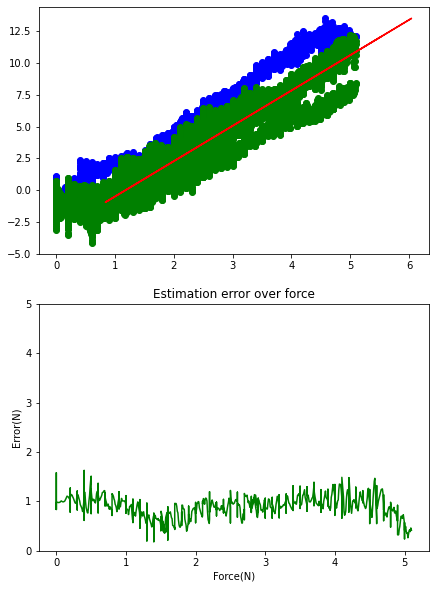

force_start 1102
force_start 358
force_start 958
force_start 1071
 
0.3341 x + 1.049
===============0===============
train on 4 combination: (2, 3, 4, 5) and test on 1


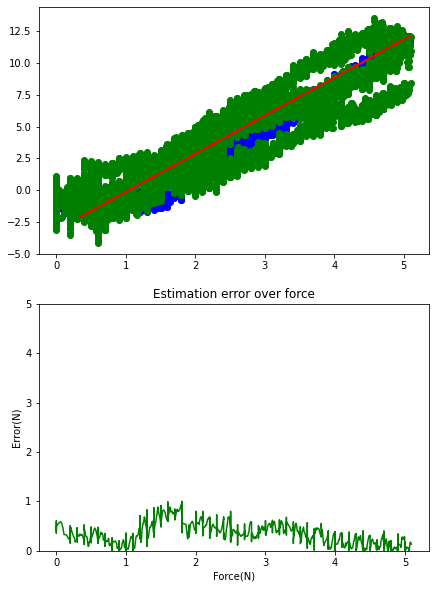

In [173]:
df_filename = integration_linear_split(ExpNo, X, Y)

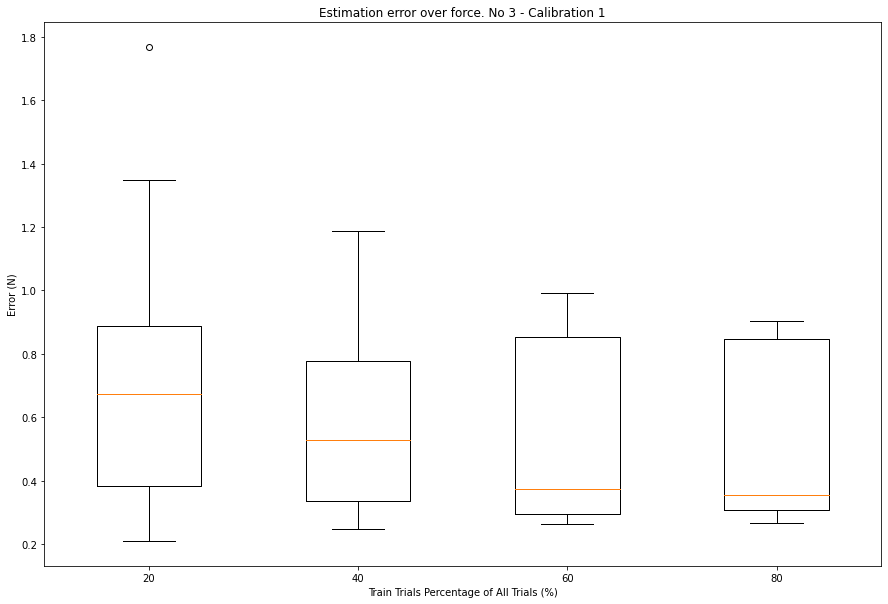

In [174]:
# df_filename = './output/cache/cali_1_No_'+str(ExpNo)+'_split.pkl'
df = pd.read_pickle(df_filename)
# print(df)
vals, names, xs = [],[],[]
for i, col in enumerate(df.columns):
    if i % 2!=0:
        continue
    vals.append(df[col].values[~np.isnan(df[col].values)])
    names.append(col)
fig, ax = plt.subplots(figsize = (15,10))
ax.boxplot(vals, widths = 0.5)
ax.set_title ('Estimation error over force. No '+str(ExpNo) +' - Calibration 1')
ax.set_xlabel ('Train Trials Percentage of All Trials (%)')
ax.set_ylabel ('Error (N)') 
# ax.set_ylim ([0,5]) 
# ax.set_xticks(range(0,6,1))
ax.set_xticklabels([20,40,60,80])
plt.show()

# full frame within one trial (calibration 2, prospect)

### only for incidence angles supp studies

In [32]:

def integration_incidence_angle_prospect(X, Y, idx): # calibration method 2
    # idx, the trial we use to train and test
    
    force_start = find_starting_point(Y[str(idx)+'_no']) 
    force_start = max(0,force_start-50)
    df = pd.DataFrame(index=range(force_end-force_start+50))
    for target in range(1,50,10):
        # data preparation
        force_target = (np.abs(Y[str(idx)+'_no'] - target)).argmin()
        
        Y_train = Y[str(idx)+'_no'][force_start:force_target]
        X_train = X[str(idx)+'_no'][force_start:force_target]
        
        # train
        Regressor = np.poly1d(np.polyfit(X_train, Y_train, 2))
        Y_pred_train = Regressor(X_train)
        print(Regressor)
            
        # test
        X_test = X[str(idx)+'_no'][force_target:]
        Y_test = Y[str(idx)+'_no'][force_target:]
        Y_pred_test = Regressor(X_test)  # make predictions

        error_value = abs(Y_pred_test-Y_test)
        r2 = r2_score(Y_test, Y_pred_test)
        print('======================================')
        print('train on 0-'+str(target)+'N, and test on '+str(target)+' to 5N')

        fig, ax = plt.subplots(2,1,figsize = (7,10))
        ax[0].scatter(Y_test, X_test, color='blue')
        ax[0].scatter(Y_train, X_train, color='green')
        ax[0].plot(Y_pred_test,X_test, color='red')
#             ax[0].set_xlim([0,5])
        ax[1].plot(Y_test,error_value, color='green')
        ax[1].set_title('Estimation error over force')
        ax[1].set_xlabel('Force(N)')
        ax[1].set_ylabel('Error(N)')
        ax[1].set_ylim([0,5])
        plt.show()

        df.loc[:,'err_'+str(target)] = pd.Series(error_value)
        df.loc[:,'r2_'+str(target)] = pd.Series(r2)   
        
    df_filename = './output/cache/cali_2_incidence_angle_'+str(idx)+'_prospect.pkl'
    df.to_pickle(df_filename) 
    return df_filename

           2
2.862e-05 x + 0.01697 x - 0.125
train on 0-1N, and test on 1 to 5N


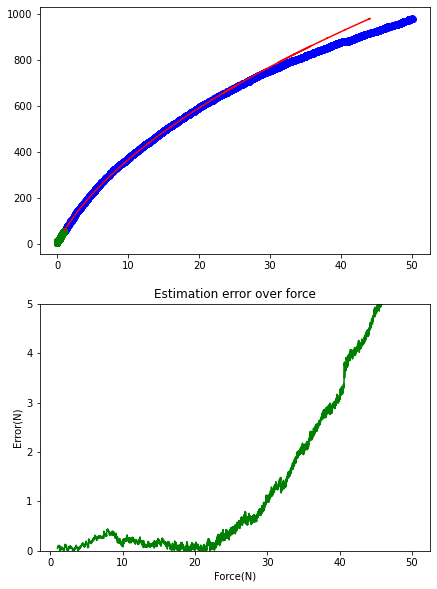

           2
3.028e-05 x + 0.01541 x - 0.02049
train on 0-11N, and test on 11 to 5N


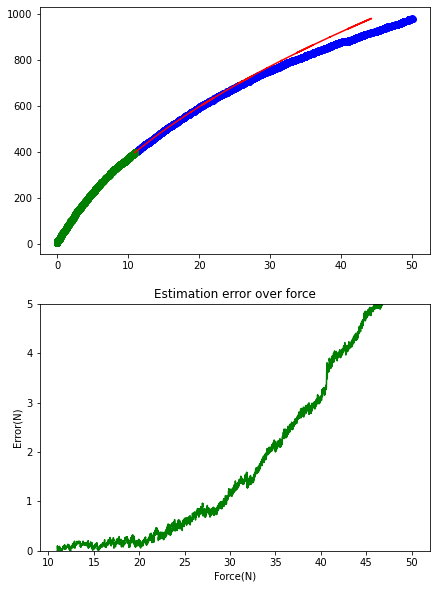

           2
3.149e-05 x + 0.01498 x + 0.0003798
train on 0-21N, and test on 21 to 5N


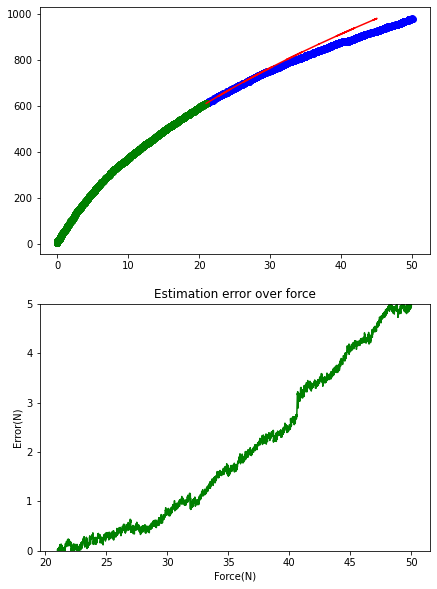

           2
3.459e-05 x + 0.01307 x + 0.2015
train on 0-31N, and test on 31 to 5N


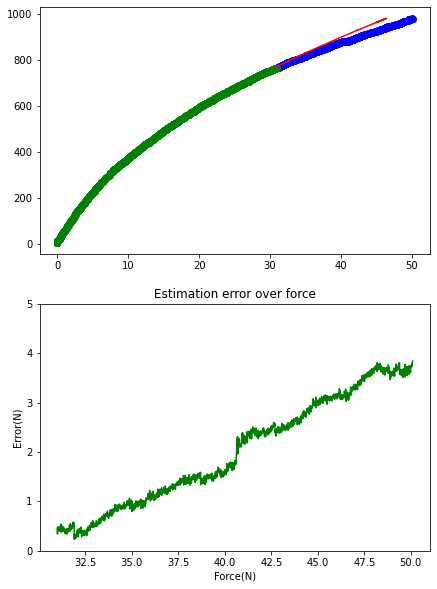

          2
4.01e-05 x + 0.008901 x + 0.7572
train on 0-41N, and test on 41 to 5N


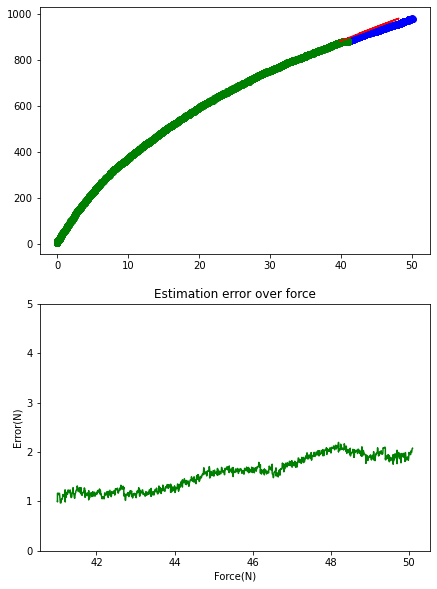

In [33]:
df_filename = integration_incidence_angle_prospect(X, Y, 21)

 
0.0369 x - 0.05699
train on 0-1N, and test on 1 to 5N


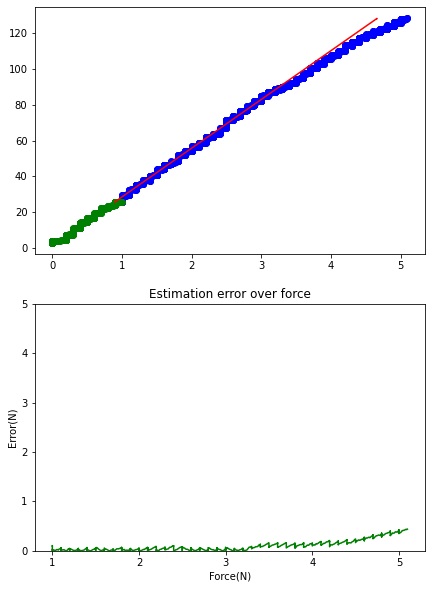

 
0.03696 x - 0.05563
train on 0-2N, and test on 2 to 5N


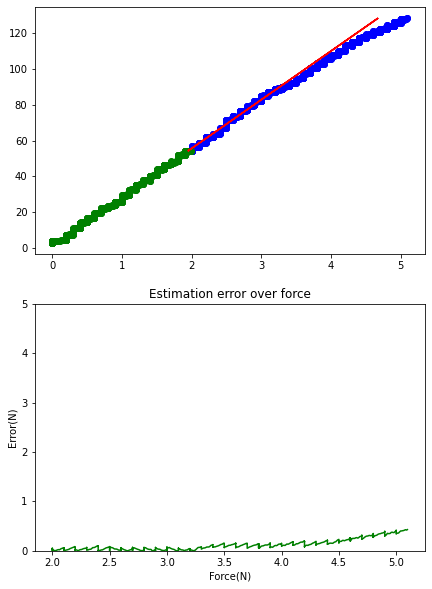

 
0.03695 x - 0.05263
train on 0-3N, and test on 3 to 5N


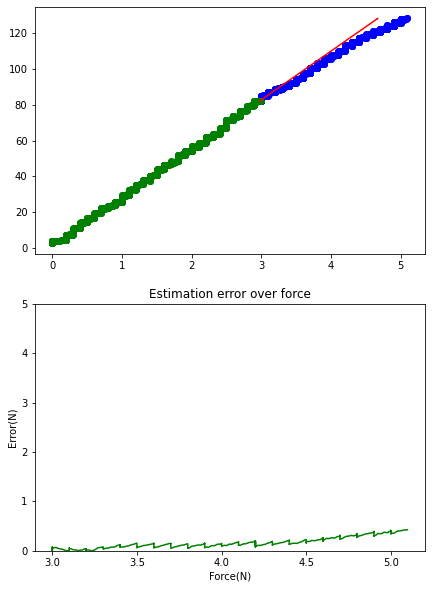

 
0.03775 x - 0.08068
train on 0-4N, and test on 4 to 5N


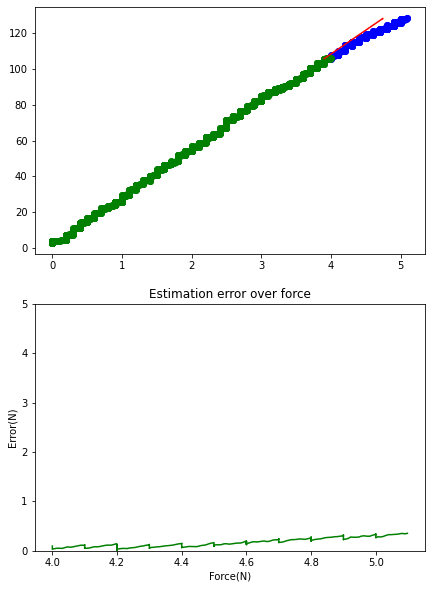

 
0.0285 x - 0.3479
train on 0-1N, and test on 1 to 5N


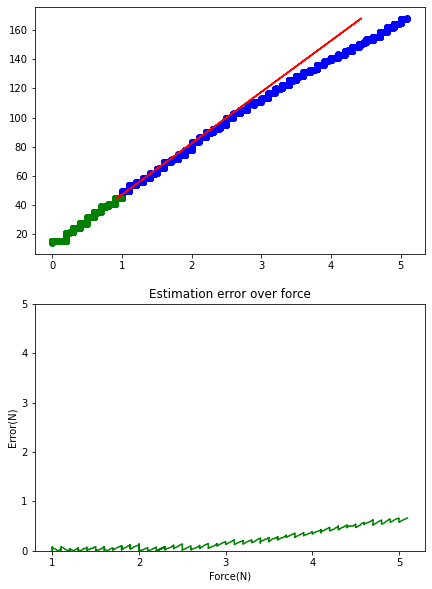

 
0.02946 x - 0.3797
train on 0-2N, and test on 2 to 5N


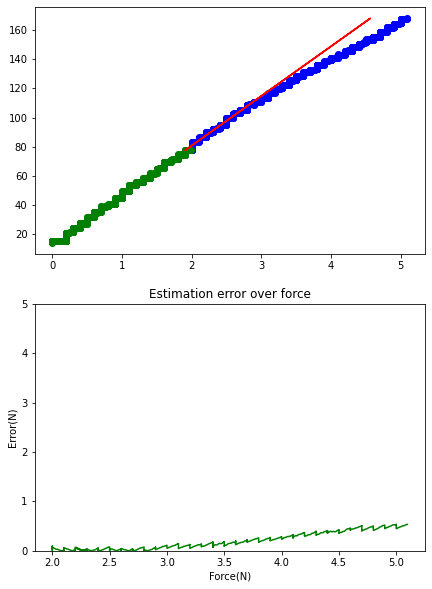

 
0.02959 x - 0.3858
train on 0-3N, and test on 3 to 5N


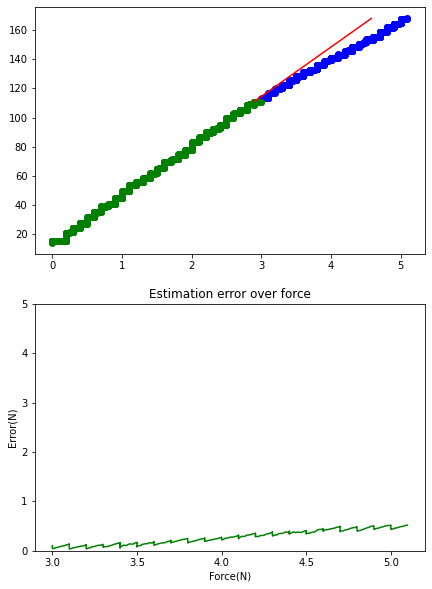

 
0.0308 x - 0.4472
train on 0-4N, and test on 4 to 5N


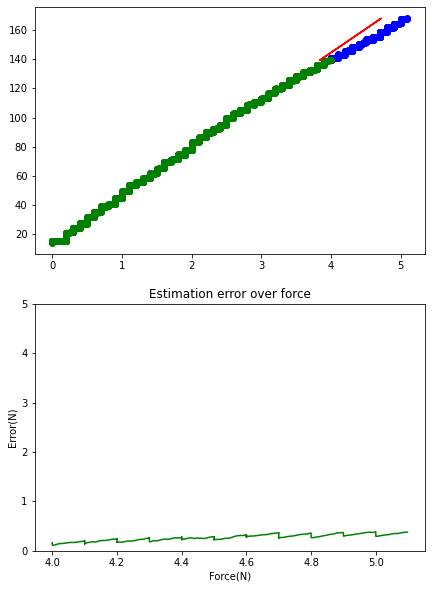

 
0.0244 x - 0.02935
train on 0-1N, and test on 1 to 5N


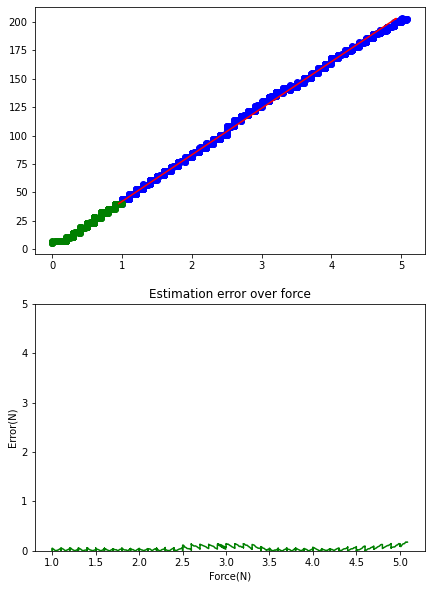

 
0.02426 x - 0.027
train on 0-2N, and test on 2 to 5N


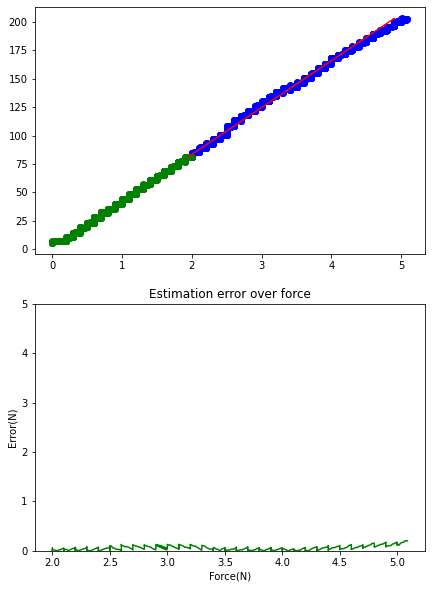

 
0.0239 x - 0.01029
train on 0-3N, and test on 3 to 5N


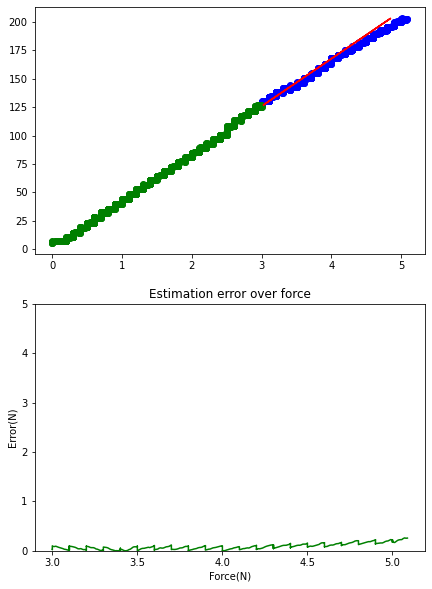

 
0.02405 x - 0.01912
train on 0-4N, and test on 4 to 5N


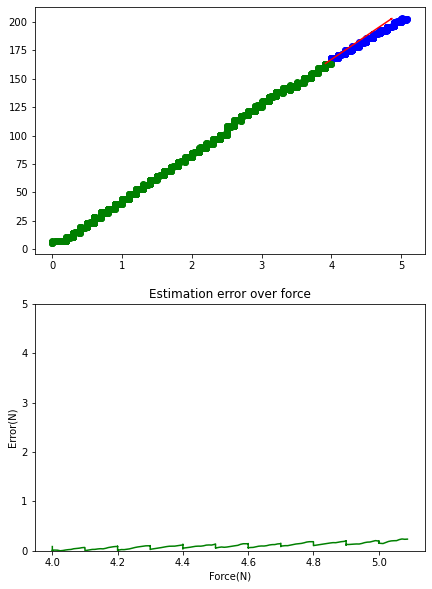

 
0.02682 x - 0.08774
train on 0-1N, and test on 1 to 5N


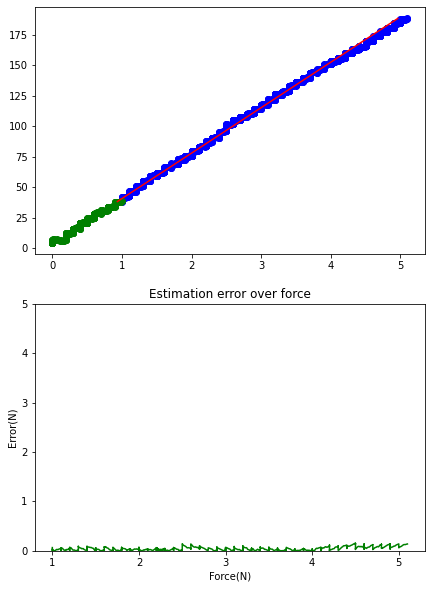

 
0.0264 x - 0.0787
train on 0-2N, and test on 2 to 5N


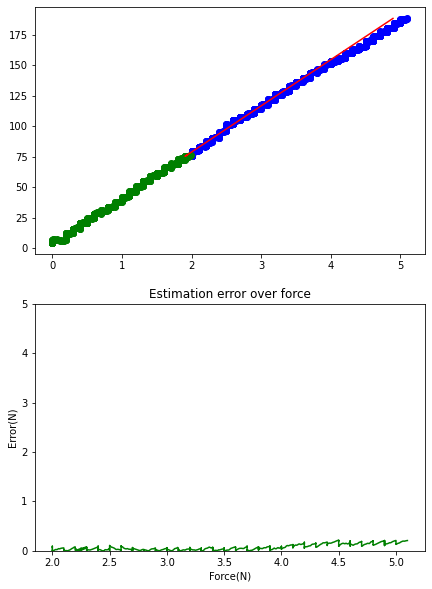

 
0.02641 x - 0.07632
train on 0-3N, and test on 3 to 5N


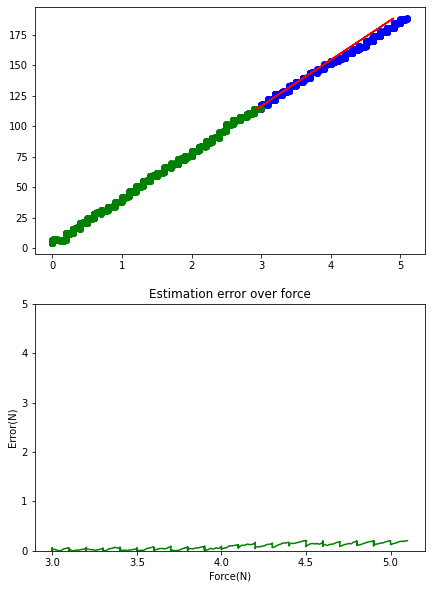

 
0.02662 x - 0.08653
train on 0-4N, and test on 4 to 5N


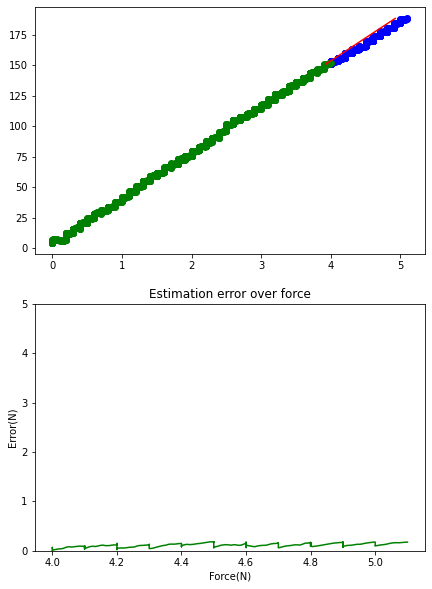

 
0.02248 x + 0.1079
train on 0-1N, and test on 1 to 5N


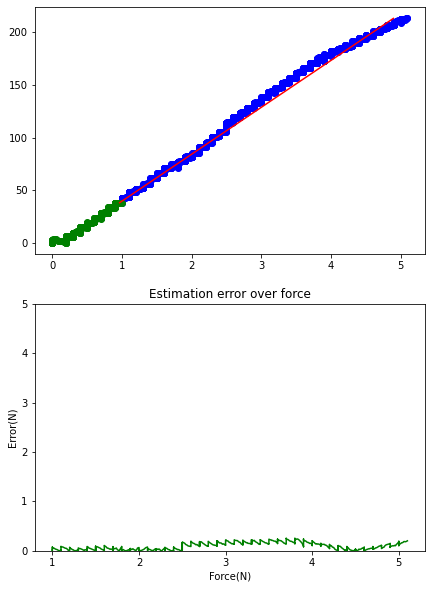

 
0.02202 x + 0.1112
train on 0-2N, and test on 2 to 5N


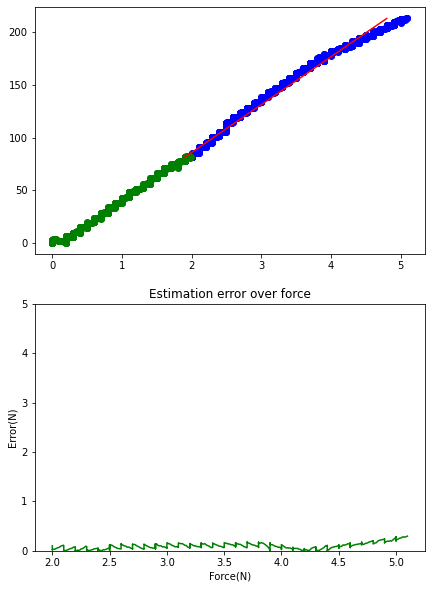

 
0.02154 x + 0.1332
train on 0-3N, and test on 3 to 5N


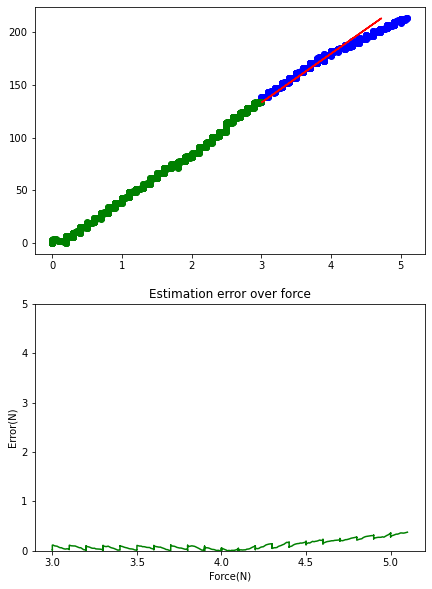

 
0.02119 x + 0.15
train on 0-4N, and test on 4 to 5N


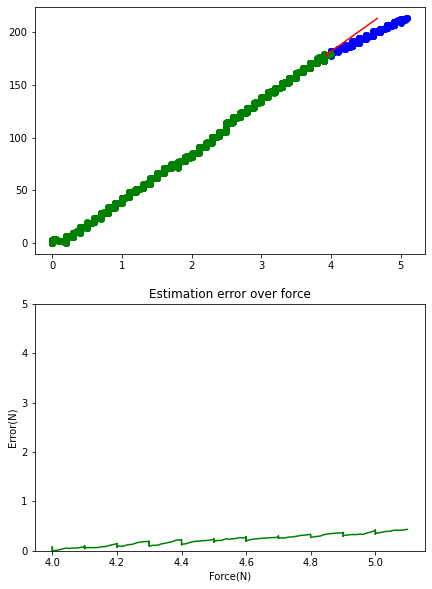

In [19]:
for no in [17,18,19,20,2]:
    df_filename = integration_incidence_angle_prospect(X, Y, no)

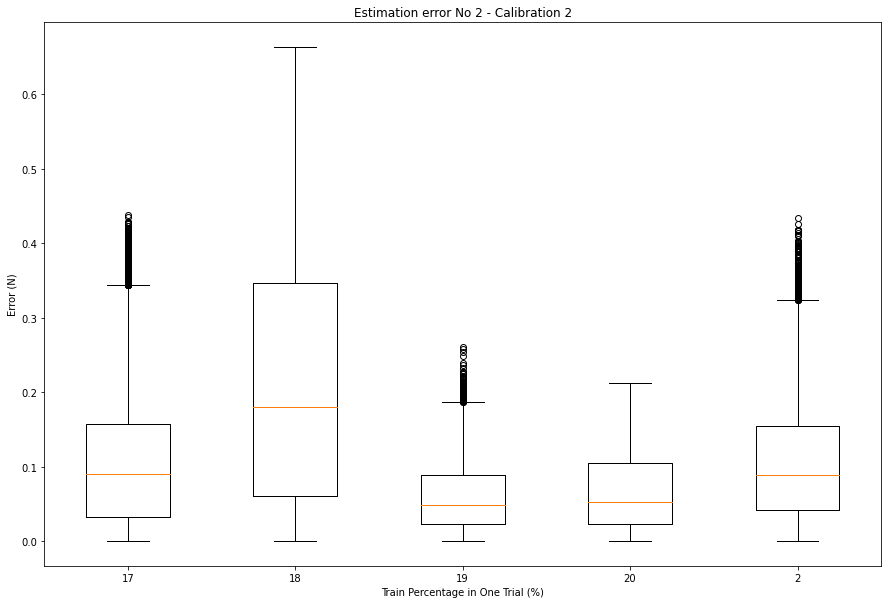

In [20]:
vals, names, xs = [],[],[]

for no in [17,18,19,20,2]:
    df_filename = './output/cache/cali_2_incidence_angle_'+str(no)+'_prospect.pkl'
    df = pd.read_pickle(df_filename)
    # print(df)
    for i, col in enumerate(df.columns):
        if i % 2!=0:
            continue
        clean_data = df[col].values[~np.isnan(df[col].values)]
        if (i == 0):
            all_col = clean_data
        else:
            all_col = np.concatenate((all_col, clean_data))
    vals.append(all_col)
fig, ax = plt.subplots(figsize = (15,10))
ax.boxplot(vals, widths = 0.5)
ax.set_title ('Estimation error No '+str(no)+' - Calibration 2')
ax.set_xlabel ('Train Percentage in One Trial (%)')
ax.set_ylabel ('Error (N)') 
# ax.set_ylim ([0,5]) 
# ax.set_xticks(range(0,6,1))
ax.set_xticklabels([17,18,19,20,2])
plt.show()

### for general use

In [24]:
###New function for gridding integration
def integration_linear_prospect(ExpNo, X, Y, idx): # calibration method 2
    # idx, the trial we use to train and test
    
    force_start = find_starting_point(Y[str(idx)+'_trial']) 
    force_start = max(0,force_start-50)
    df = pd.DataFrame(index=range(force_end-force_start+50))
    for target in range(1,5):
        # data preparation
        force_target = (np.abs(Y[str(idx)+'_trial'] - target)).argmin()
        
        Y_train = Y[str(idx)+'_trial'][force_start:force_target]
        X_train = X[str(idx)+'_trial'][force_start:force_target]
        
        # train
        Regressor = np.poly1d(np.polyfit(X_train, Y_train, 1))
        Y_pred_train = Regressor(X_train)
        print(Regressor)
            
        # test
        X_test = X[str(idx)+'_trial'][force_target:]
        Y_test = Y[str(idx)+'_trial'][force_target:]
        Y_pred_test = Regressor(X_test)  # make predictions

        error_value = abs(Y_pred_test-Y_test)
        r2 = r2_score(Y_test, Y_pred_test)
        print('======================================')
        print('train on 0-'+str(target)+'N, and test on '+str(target)+' to 5N')

        fig, ax = plt.subplots(2,1,figsize = (7,10))
        ax[0].scatter(Y_test, X_test, color='blue')
        ax[0].scatter(Y_train, X_train, color='green')
        ax[0].plot(Y_pred_test,X_test, color='red')
#             ax[0].set_xlim([0,5])
        ax[1].plot(Y_test,error_value, color='green')
        ax[1].set_title('Estimation error over force')
        ax[1].set_xlabel('Force(N)')
        ax[1].set_ylabel('Error(N)')
        ax[1].set_ylim([0,5])
        plt.show()

        df.loc[:,'err_'+str(target)] = pd.Series(error_value)
        df.loc[:,'r2_'+str(target)] = pd.Series(r2)   
        
    df_filename = './output/cache/cali_2_No_'+str(ExpNo)+'_'+str(idx)+'_prospect.pkl'
    df.to_pickle(df_filename) 
    return df_filename

In [25]:
for trial in range(3,4):
    df_filename = integration_linear_prospect(ExpNo, X, Y, trial)

KeyError: '3_trial'

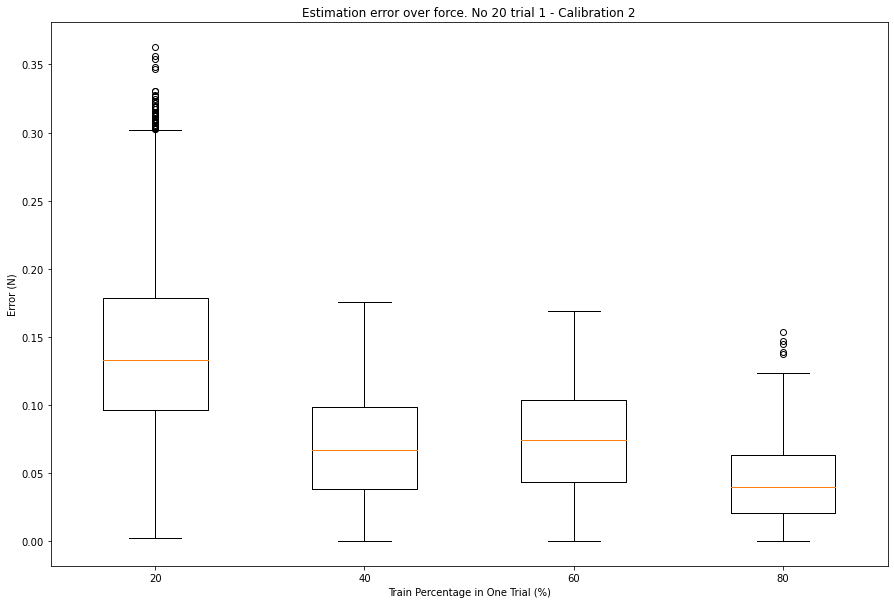

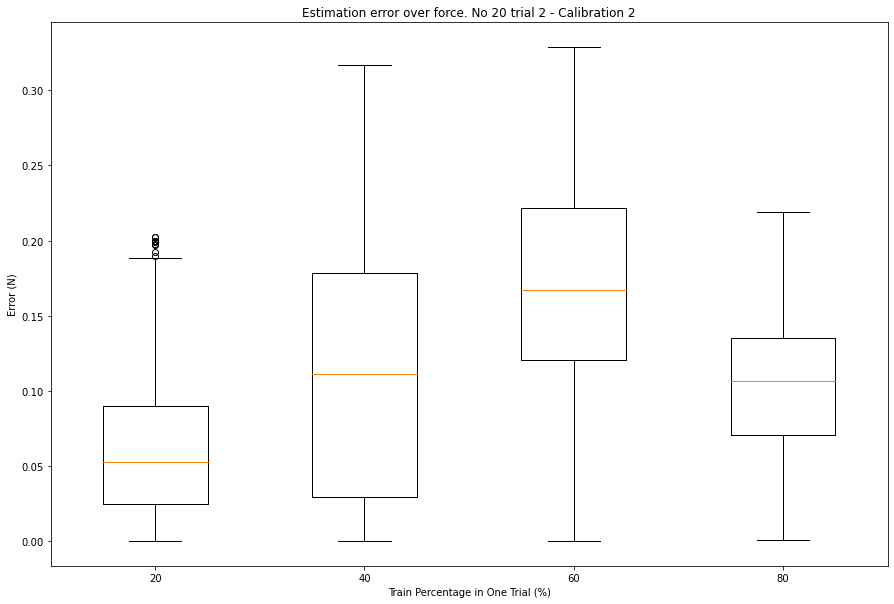

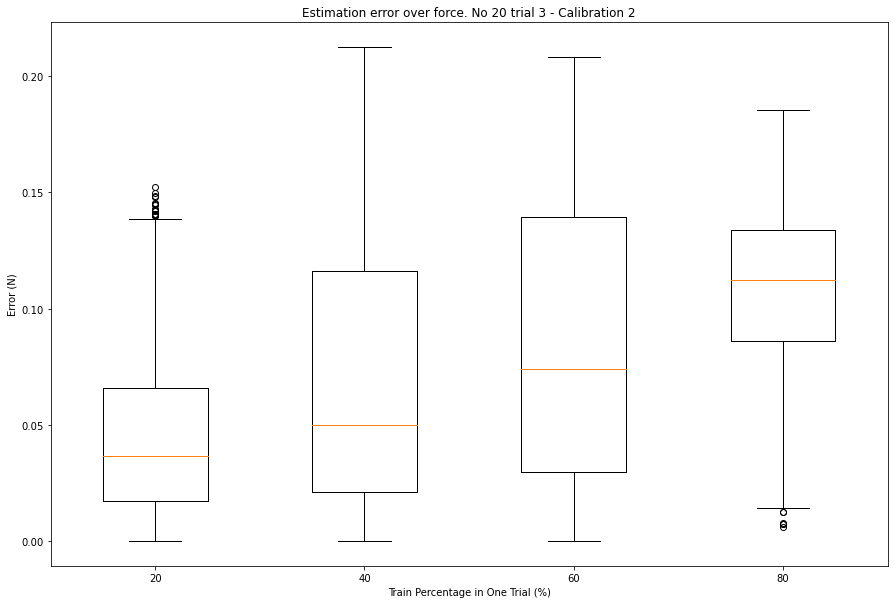

In [10]:
for trial in range(1,4):
    df_filename = './output/cache/cali_2_No_'+str(ExpNo)+'_'+str(trial)+'_prospect.pkl'
    df = pd.read_pickle(df_filename)
    # print(df)
    vals, names, xs = [],[],[]
    for i, col in enumerate(df.columns):
        if i % 2!=0:
            continue
        vals.append(df[col].values[~np.isnan(df[col].values)])
        names.append(col)
    fig, ax = plt.subplots(figsize = (15,10))
    ax.boxplot(vals, widths = 0.5)
    ax.set_title ('Estimation error over force. No '+str(ExpNo)+' trial '+str(trial)+' - Calibration 2')
    ax.set_xlabel ('Train Percentage in One Trial (%)')
    ax.set_ylabel ('Error (N)') 
    # ax.set_ylim ([0,5]) 
    # ax.set_xticks(range(0,6,1))
    ax.set_xticklabels([20,40,60,80])
    plt.show()

# full frame over force

In [ ]:
###New function for gridding integration
def integration_linear(ExpNo, X, Y):
    #vel_tensor: shape (T x H x W )
    #grid_sz: in subsampled grid units, size of grid for velocity estimate, even int
    #grid_stride: in subsampled grid units, stride of grid for velocity estimate, int
    #flow_grid: in pixels, subsampling size of optical flow matrix, int
    #center: touch location (x,y)
    #mask: mask of regions within and outside actuator
    #window: number of velocities timeframes to average over for denoising
    #return - all_vel_ts: dictionary of vectors of length T; each key is in format row_col
    
    df = pd.DataFrame() 
    counter = 0
#     errors = np.zeros((5,4))
    r2s = np.zeros((5,4))
    error_values = np.zeros((5,4,10))
    
    bin_edges=np.arange(0, 5.5 ,0.5)
    
    for train in range(1,6):
    # train
        force_start = find_starting_point(gt_force_dict[str(train)+'_trial'])
        X_train = X[str(train)+'_trial'][force_start:]
        Y_train = Y[str(train)+'_trial'][force_start:]
        Regressor = np.poly1d(np.polyfit(X_train, Y_train, 1))
        Y_pred_train = Regressor(X_train)
        print(Regressor)
        # test
        counter = 0
        for test in range(1,6):
            if test == train:
                continue
            # test
            force_start = find_starting_point(gt_force_dict[str(test)+'_trial'])
            X_test = X[str(test)+'_trial'][force_start:]
            Y_test = Y[str(test)+'_trial'][force_start:]
            Y_pred_test = Regressor(X_test)  # make predictions
            
#             error = abs(Y_pred_test-Y_test)/Y_test
            error_value = abs(Y_pred_test-Y_test)
            error_value_bins, _, _ = stats.binned_statistic(Y_test, error_value,
                                                                        statistic='mean', bins=bin_edges)
#             error = np.where(abs(error)>1, 0, error)
#             print(error)
#             error_avg = np.mean(error)
#             errors[train-1][counter] = error_avg
            error_values[train-1][counter] = error_value_bins
            r2s[train-1][counter] = r2_score(Y_test, Y_pred_test)
            print('==============='+str(counter)+'===============')
            print('train on '+str(train)+' test on '+str(test))
            arr = np.concatenate((error_value_bins,[r2s[train-1][counter]]))
            row = pd.Series(arr)
            df = df.append(row, ignore_index=True)
#             df[str(train)+'_'+str(test)] = np.transpose(error_value_bins)
            
            fig, ax = plt.subplots(2,1,figsize = (7,10))
            ax[0].scatter(Y_test, X_test, color='blue')
            ax[0].scatter(Y_train, X_train, color='green')
            ax[0].plot(Y_pred_test,X_test, color='red')
#             ax[0].set_xlim([0,5])
#             ax[1].hlines(error_value_bins, bin_edges[:-1], bin_edges[1:], colors='g', lw=2)
            ax[1].plot(Y_test,error_value, color='green')
            ax[1].set_title('Estimation error over force')
            ax[1].set_xlabel('Force(N)')
            ax[1].set_ylabel('Error(N)')
            ax[1].set_ylim([0,5])
            plt.show()
            counter+=1
            
    df_filename = './output/cache/cali_1_No_'+str(ExpNo)+'_full_frame.pkl'
    df.to_pickle(df_filename) 
    return df_filename

In [ ]:
df_filename= integration_linear(ExpNo, X, Y)

In [ ]:
# df_filename = './output/cache/cali_1_No_'+str(ExpNo)+'_full_frame_.pkl'
df = pd.read_pickle(df_filename)
bin_edges=np.arange(0, 5.5 ,0.5)
# print(df)
vals, names, xs = [],[],[]
for i, col in enumerate(df.columns):
    if i == 10:
        continue
    vals.append(df[col].values)
    names.append(str(0.5*i-0.25))
fig, ax = plt.subplots(figsize = (15,10))
sns.reset_orig
ax.boxplot(vals, widths = 0.5,positions=bin_edges[1:]-0.25)
ax.set_title ('Estimation error over force. No '+str(ExpNo))
ax.set_xlabel ('Force (N)')
ax.set_ylabel ('Error (N)') 
# ax.set_ylim ([0,5]) 
ax.set_xticks(range(0,6,1))
ax.set_xticklabels([0,1,2,3,4,5])
plt.show()

# over force

In [ ]:
###New function for gridding integration
###use only when you read 5 tirals of data
def grid_integration_linear_over_force(velocities_dict, grid_sz, grid_stride, center, mask_compact, window = 1):
    #vel_tensor: shape (T x H x W )
    #grid_sz: in subsampled grid units, size of grid for velocity estimate, even int
    #grid_stride: in subsampled grid units, stride of grid for velocity estimate, int
    #flow_grid: in pixels, subsampling size of optical flow matrix, int
    #center: touch location (x,y)
    #mask: mask of regions within and outside actuator
    #window: number of velocities timeframes to average over for denoising
    #return - all_vel_ts: dictionary of vectors of length T; each key is in format row_col
    df = pd.DataFrame() 
    Lyy = np.arange(0,1536,4)
    Lxx = np.arange(0,2048,4)
    LX,LY = np.meshgrid(Lxx,Lyy)
    dir_x = gt_x - LX
    dir_y = gt_y - LY
    dir_x = dir_x/(np.sqrt(dir_x**2+dir_y**2))
    dir_y = dir_y/(np.sqrt(dir_x**2+dir_y**2))
    
    bin_edges=np.arange(-0.05, 5.15 ,0.1)
    
    half_grid_sz = int(grid_sz/2)
    flow_grid  = 4
    
    r2_overall = []
    error_overall = []
    error_value_overall = []
    for r1 in range(half_grid_sz,384-half_grid_sz,grid_stride):
        for c1 in range(half_grid_sz,512-half_grid_sz,grid_stride):
            row1 = int(r1)
            col1 = int(c1)
            start_r = int((r1-half_grid_sz))
            end_r = int((r1+half_grid_sz))
            start_c = int((c1-half_grid_sz))
            end_c = int((c1+half_grid_sz))
            
            if np.all(mask_compact[start_r:end_r,start_c:end_c]!=0):  
#                 dist = np.sqrt((center[0]-(c1*flow_grid))**2+(center[1]-(r1*flow_grid))**2)
#                 print('dist to center ', dist) 
#                 #save direction
#                 cur_d_x = dir_x[row1,col1]
#                 cur_d_y = dir_y[row1,col1]
#                 dir_angle = np.arctan2(cur_d_y,cur_d_x)-np.pi
                
#                 v1 = c1
#                 v2 = r1
#                 v3 = dist
#                 v4 = dir_angle
                
                r2_train = np.zeros((5,4))
                error_train = np.zeros((5,4,51))
                error_value_train = np.zeros((5,4,51))
                r2_ROI = 0
                error_ROI = np.zeros(51)
                error_value_ROI = np.zeros(51)
                for train in range(1,6):
                    # train
#                     print('valid ROI (x,y)',c1,r1)
                    velocities_train = velocities_dict[str(train)+'_trial']
                    velocities_train = velocities_train[:,row1-half_grid_sz:row1+half_grid_sz,
                                                        col1-half_grid_sz:col1+half_grid_sz]
                    gt_force_train = gt_force_dict[str(train)+'_trial']
                    mean_velocity = np.mean(velocities_train, axis=(1,2))
                    est_force_train = np.cumsum(mean_velocity)
                    force_end = find_ending_point(est_force_train, gt_force_train)
                    force_start = find_starting_point(gt_force_train)
                    X_train = est_force_train[force_start:force_end]
                    Y_train = gt_force_train[force_start:force_end]
                    linear_regressor = np.poly1d(np.polyfit(X_train, Y_train, 1))  # create object for the class
#                     Y_pred_train = linear_regressor.predict(X_train)  # make predictions
    #                 r2_train = linear_regressor.score(X_train,Y_train)
    #                 error = abs(Y_pred_train-Y_train)/Y_train
    #                 error_avg = np.mean(error)
                    print("trained model: ",linear_regressor)
                    # test
                    r2_test = np.zeros(4)
                    error_test = np.zeros((4,51))
                    error_value_test = np.zeros((4,51))
                    counter = 0
                    for test in range(1,6):
                        if test == train:
                            continue
                        # test
                        velocities_test = velocities_dict[str(test)+'_trial']
                        velocities_test = velocities_test[:,row1-half_grid_sz:row1+half_grid_sz,
                                                        col1-half_grid_sz:col1+half_grid_sz]
                        gt_force_test = gt_force_dict[str(test)+'_trial']
                        mean_velocity = np.mean(velocities_test, axis=(1,2))
                        est_force_test = np.cumsum(mean_velocity)
                        force_end = find_ending_point(est_force_test, gt_force_test)
                        force_start = find_starting_point(gt_force_test)
                        X_test = est_force_test[force_start:force_end]
                        Y_test = gt_force_test[force_start:force_end]
                        Y_pred_test = linear_regressor(X_test)  # make predictions
                        
                        error = abs(Y_pred_test-Y_test)/Y_test
                        error_value = abs(Y_pred_test-Y_test)
                        error = np.where(abs(error)==math.inf, 0, error)
                        error_bins, _, _ = stats.binned_statistic(Y_test, error, 
                                                                  statistic='mean', bins=bin_edges)
                        error_value_bins, _, _ = stats.binned_statistic(Y_test, error_value,
                                                                        statistic='mean', bins=bin_edges)
                        r2_test[counter]=r2_score(Y_test,Y_pred_test)
                        error_test[counter] = error_bins
                        error_value_test[counter] = error_value_bins
                        print("train",train,"test",test)
                        
                        fig, ax = plt.subplots(figsize = (7,5))
                        ax.hlines(100*error_bins, bin_edges[:-1], bin_edges[1:], colors='g', lw=2)
#                         ax.hlines(error_value_bins, bin_edges[:-1], bin_edges[1:], colors='g', lw=2)
#                         ax.scatter(Y_test,100*error)
#                         ax.scatter(Y_test,X_test, color='b')
#                         ax.scatter(Y_pred_test,X_test, color = 'r')
#                         ax.set_title('Estimation error over force')
#                         ax.set_xlabel('force')
#                         ax.set_ylabel('Error %')
#                         ax.set_xlim([0,5.1])
#                         ax.set_ylim([0,10])
                        plt.show()
                        counter += 1
                    r2_train[train-1]=r2_test
                    error_train[train-1]=error_test
                    error_value_train[train-1]=error_value_test
                
#                 v1 = np.mean(np.array(r2_train))
#                 v2 = np.std(np.array(error_train))
#                 v3 = np.mean(np.array(error_train))
#                 v4 = np.mean(np.array(error_value_train))
                r2_ROI = np.mean(r2_train,axis=(0,1)).reshape(-1)
                error_ROI = np.mean(error_train,axis=(0,1)).reshape(-1)
                error_value_ROI = np.mean(error_value_train,axis=(0,1)).reshape(-1)
                r2_overall.append(r2_ROI)
                error_overall.append(error_ROI)
                error_value_overall.append(error_value_ROI)
                arr = np.concatenate((error_value_ROI,r2_ROI))
#                 print(error_value_ROI.shape)
#                 print(r2_ROI.shape)
                row = pd.Series(arr)
                df = df.append(row, ignore_index=True)
    v1 = np.mean(np.array(r2_overall))
    v2 = np.std(np.array(error_overall))
    v3 = np.mean(np.array(error_overall))
    v4 = np.mean(np.array(error_value_overall))
    
    
#     df_filename = './output/cache/cali_1_No_7_over_force_.pkl'
#     df.to_pickle(df_filename)  
    return df_filename, v1, v2, v3, v4

In [ ]:
grid_sz = 80# SMALLER, the loops MORE COMPLETE
grid_stride = 50# SMALLER, the gap between every two loops and every two elements in the loop SMALLER
center = (gt_x,gt_y)
df_filename, v1, v2, v3, v4 = grid_integration_linear_over_force(velocities_dict, 
                                      grid_sz, grid_stride, 
                                      center, mask_comp, 
                                      window = 1)

# hex_overall = []
# for angle in angle_overall:
#     scaled_angle = 200*(angle-np.pi)/(2*np.pi)
#     out = colorsys.hls_to_rgb(scaled_angle/360, 0.6, 0.8)
#     hex_overall.append(out)
    # hex = rgb_to_hex(int(255*r), int(255*g), int(255*b))
    # hex_list.append(hex)

# hex_overall2 = np.array(hex_overall)
#Plot chart as above, but change the plot type from 'o' to '*' - givng us stars!
# plt.scatter(dist_overall,error_overall,s=100, c=hex_overall2)

In [ ]:
# df_filename = './output/cache/cali_1_No_7_over_force.pkl'
df = pd.read_pickle(df_filename)
# print(df)
vals, names, xs = [],[],[]
for i, col in enumerate(df.columns):
    if i == 51:
        continue
    vals.append(1000*df[col].values/(i))
    names.append(str(0.1*i))
fig, ax = plt.subplots(figsize = (15,10))
ax.boxplot(vals,widths = 0.8)

ax.set_title ('Estimation error over force. No 7')
ax.set_xlabel ('Force (N)')
ax.set_ylabel ('Error%') 
ax.set_ylim ([0,100]) 
ax.set_xticks(range(1,52,10))
ax.set_xticklabels(['0','1','2','3','4','5'])
plt.show()

# over distance

In [ ]:
###New function for gridding integration
###use only when you read 5 tirals of data
def grid_integration_linear_over_dist(velocities_dict, grid_sz, grid_stride, center, mask_compact, window = 1):
    #vel_tensor: shape (T x H x W )
    #grid_sz: in subsampled grid units, size of grid for velocity estimate, even int
    #grid_stride: in subsampled grid units, stride of grid for velocity estimate, int
    #flow_grid: in pixels, subsampling size of optical flow matrix, int
    #center: touch location (x,y)
    #mask: mask of regions within and outside actuator
    #window: number of velocities timeframes to average over for denoising
    #return - all_vel_ts: dictionary of vectors of length T; each key is in format row_col
    df = pd.DataFrame(columns=['x','y','distance','angle',
                               'abs_error_avg','error_avg','error_std','r2_avg'])    
    Lyy = np.arange(0,1536,4)
    Lxx = np.arange(0,2048,4)
    LX,LY = np.meshgrid(Lxx,Lyy)
    dir_x = gt_x - LX
    dir_y = gt_y - LY
    dir_x = dir_x/(np.sqrt(dir_x**2+dir_y**2))
    dir_y = dir_y/(np.sqrt(dir_x**2+dir_y**2))
    
    half_grid_sz = int(grid_sz/2)
    flow_grid  = 4

    for r1 in range(half_grid_sz,384-half_grid_sz,grid_stride):
        for c1 in range(half_grid_sz,512-half_grid_sz,grid_stride):
            row1 = int(r1)
            col1 = int(c1)
            start_r = int((r1-half_grid_sz))
            end_r = int((r1+half_grid_sz))
            start_c = int((c1-half_grid_sz))
            end_c = int((c1+half_grid_sz))
            
            if np.all(mask_compact[start_r:end_r,start_c:end_c]!=0):  
                dist = np.sqrt((center[0]-(c1*flow_grid))**2+(center[1]-(r1*flow_grid))**2)
#                 print('dist to center ', dist) 
                #save direction
                cur_d_x = dir_x[row1,col1]
                cur_d_y = dir_y[row1,col1]
                dir_angle = np.arctan2(cur_d_y,cur_d_x)-np.pi
                
                v1 = c1
                v2 = r1
                v3 = dist
                v4 = dir_angle
                
                r2_train = []
                error_train = []
                error_value_train = []
                for train in range(1,6):
                    # train
                    print('valid ROI (x,y)',c1,r1)
                    velocities_train = velocities_dict[str(train)+'_trial']
                    velocities_train = velocities_train[:,row1-half_grid_sz:row1+half_grid_sz,
                                                        col1-half_grid_sz:col1+half_grid_sz]
                    gt_force_train = gt_force_dict[str(train)+'_trial']
                    mean_velocity = np.mean(velocities_train, axis=(1,2))
                    est_force_train = np.cumsum(mean_velocity)
                    force_end = find_ending_point(est_force_train, gt_force_train)
                    force_start = find_starting_point(gt_force_train)
                    X_train = est_force_train[force_start:force_end].reshape(-1, 1)
                    Y_train = gt_force_train[force_start:force_end].reshape(-1, 1)
                    linear_regressor = LinearRegression()  # create object for the class
                    linear_regressor.fit(X_train, Y_train)  # perform linear regression
                    Y_pred_train = linear_regressor.predict(X_train)  # make predictions
    #                 r2_train = linear_regressor.score(X_train,Y_train)
    #                 error = abs(Y_pred_train-Y_train)/Y_train
    #                 error_avg = np.mean(error)
                    slope = linear_regressor.coef_
                    intercept = linear_regressor.intercept_
                    print("trained model: slope "+str(slope)+" intercept "+str(intercept))
                    # test
                    r2_test = []
                    error_test = []
                    error_value_test = []
                    for test in range(1,6):
                        if test == train:
                            continue
                        # test
                        velocities_test = velocities_dict[str(test)+'_trial']
                        velocities_test = velocities_test[:,row1-half_grid_sz:row1+half_grid_sz,
                                                        col1-half_grid_sz:col1+half_grid_sz]
                        gt_force_test = gt_force_dict[str(test)+'_trial']
                        mean_velocity = np.mean(velocities_test, axis=(1,2))
                        est_force_test = np.cumsum(mean_velocity)
                        force_end = find_ending_point(est_force_test, gt_force_test)
                        force_start = find_starting_point(gt_force_test)
                        X_test = est_force_test[force_start:force_end].reshape(-1, 1)
                        Y_test = gt_force_test[force_start:force_end].reshape(-1, 1)
                        Y_pred_test = linear_regressor.predict(X_test)  # make predictions
                        r2_test.append(linear_regressor.score(X_test,Y_test))
                        error = abs(Y_pred_test-Y_test)/Y_test
                        error_value = abs(Y_pred_test-Y_test)
                        error = np.where(abs(error)>1, 0, error)
    #                     print(error)
                        error_avg = np.mean(error)
                        error_value_avg = np.mean(error_value)
                        error_test.append(error_avg)
                        error_value_test.append(error_value_avg)
                            
                        print("train on ",train, " test on ", test)
                        fig, ax = plt.subplots(2,1,figsize = (7,10))
                        ax[0].plot(range(len(X_test)),X_test)
#                         ax[0].scatter(Y_test,X_test)
#                         ax[0].plot(Y_pred_test, X_test, color='red')
                        ax[1].plot(Y_test,error_value, color='green')
                        ax[1].set_title('Estimation error over force')
                        ax[1].set_xlabel('force')
                        ax[1].set_ylabel('Error %')
                        ax[1].set_ylim([0,100])
                        plt.show()

                    r2_train+=r2_test
                    error_train+=error_test
                    error_value_train+=error_value_test
                v8 = np.mean(np.array(r2_train))
                v7 = np.std(np.array(error_train))
                v6 = np.mean(np.array(error_train))
                v5 = np.mean(np.array(error_value_train))

                row = pd.Series({'x':v1,'y':v2,'distance':v3,'angle':v4,
                               'abs_error_avg':v5,'error_avg':v6,'error_std':v7,'r2_avg':v8})
                df = df.append(row, ignore_index=True)

    df_filename = './output/cache/cali_1_No_7.pkl'
    df.to_pickle(df_filename)  
    return df_filename

In [ ]:
grid_sz = 50# SMALLER, the loops MORE COMPLETE
grid_stride = 50# SMALLER, the gap between every two loops and every two elements in the loop SMALLER
center = (gt_x,gt_y)
df_filename = grid_integration_linear_over_dist(velocities_dict, 
                                      grid_sz, grid_stride, 
                                      center, mask_comp, 
                                      window = 1)

# hex_overall = []
# for angle in angle_overall:
#     scaled_angle = 200*(angle-np.pi)/(2*np.pi)
#     out = colorsys.hls_to_rgb(scaled_angle/360, 0.6, 0.8)
#     hex_overall.append(out)
    # hex = rgb_to_hex(int(255*r), int(255*g), int(255*b))
    # hex_list.append(hex)

# hex_overall2 = np.array(hex_overall)
#Plot chart as above, but change the plot type from 'o' to '*' - givng us stars!
# plt.scatter(dist_overall,error_overall,s=100, c=hex_overall2)

In [ ]:
df = pd.read_pickle(df_filename)
print(df)
df.plot.scatter(x="distance", y="error_avg",alpha=0.5)

# Color coding

In [ ]:
hex_overall = []
for angle in angle_overall:
    scaled_angle = 360*(angle-np.pi)/(2*np.pi)
    out = colorsys.hls_to_rgb(scaled_angle/360, 0.6, 0.8)
    hex_overall.append(out)
    # hex = rgb_to_hex(int(255*r), int(255*g), int(255*b))
    # hex_list.append(hex)

hex_overall2 = np.array(hex_overall)
plt.ylim([0,20])
plt.scatter(dist_overall,100*np.array(error_overall),s=10, marker='x',c=hex_overall2)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
plt.ylim([0,20])
ax.set_title('Estimation error distribution across distances and angles')
ax.set_xlabel('Distance (pixel)')
ax.set_ylabel('Error %')
plt.scatter(dist_overall,100*np.array(error_overall),s=50, marker='x',c=hex_overall2)
# with open('./output/cache/error_ExpNo_1_cali_1.npy', 'wb') as f:
#         np.save(f, np.array(dist_overall))
#         np.save(f, np.array(error_overall))
#         np.save(f, np.array(angle_overall))
#         print('finish writing')
# plt.savefig('error_ExpNo_1_cali_1.png')

In [ ]:
grid_sz = 50# SMALLER, the loops MORE COMPLETE
grid_stride = 5# SMALLER, the gap between every two loops and every two elements in the loop SMALLER
ix_cur = 2700

vel_list,dist_list,angle_list = grid_vels(ix_cur, velocities_dict['1_trial'], grid_sz, grid_stride, 4, (1035, 540), mask_comp, window = 1)

In [ ]:
fig, ax = plt.subplots()
#     print(4*gt_x,4*gt_y)
#     print(len(vel_list))
#Set plot size
fig.set_size_inches(7, 5)
ax.set_title('velocity vs distance at '+str(ix_cur)+ ' frame')
ax.set_xlabel('distance')
ax.set_ylabel('velocity')
plt.ylim([0,1.5])

#Plot chart as above, but change the plot type from 'o' to '*' - givng us stars!
# plt.plot(dist_list,vel_list,"*")
# plt.savefig(str(ix_cur)+'.png')
# plt.show()

hex_list = []
for angle in angle_list:
    scaled_angle = 200*(angle-np.pi)/(2*np.pi)
    out = colorsys.hls_to_rgb(scaled_angle/360, 0.6, 0.8)
    hex_list.append(out)
    # hex = rgb_to_hex(int(255*r), int(255*g), int(255*b))
    # hex_list.append(hex)

hex_list2 = np.array(hex_list)

#Plot chart as above, but change the plot type from 'o' to '*' - givng us stars!
plt.scatter(dist_list,vel_list,s=100, c=hex_list2)

In [ ]:
###New function for gridding velocities
def grid_vels(ix_cur, velocities, grid_sz, grid_stride, flow_grid, center, mask_compact, window = 1):
    #vel_tensor: shape (T x H x W )
    #grid_sz: in subsampled grid units, size of grid for velocity estimate, even int
    #grid_stride: in subsampled grid units, stride of grid for velocity estimate, int
    #flow_grid: in pixels, subsampling size of optical flow matrix, int
    #center: touch location (x,y)
    #mask: mask of regions within and outside actuator
    #window: number of velocities timeframes to average over for denoising
    #return - all_vel_ts: dictionary of vectors of length T; each key is in format row_col
    Lyy = np.arange(0,1536,4)
    Lxx = np.arange(0,2048,4)
    LX,LY = np.meshgrid(Lxx,Lyy)
    dir_x = gt_x - LX
    dir_y = gt_y - LY
    dir_x = dir_x/(np.sqrt(dir_x**2+dir_y**2))
    dir_y = dir_y/(np.sqrt(dir_x**2+dir_y**2))
    
    half_grid_sz = int(grid_sz/2)
    # all_vel_ts = {}
    vel_list = []
    dist_list = []
    angle_list = []
    for r1 in range(half_grid_sz,384-half_grid_sz,grid_stride):
        for c1 in range(half_grid_sz,512-half_grid_sz,grid_stride):
            row1 = int(r1)
            col1 = int(c1)
            start_r = int((r1-half_grid_sz))
            end_r = int((r1+half_grid_sz))
            start_c = int((c1-half_grid_sz))
            end_c = int((c1+half_grid_sz))
            if np.all(mask_compact[start_r:end_r,start_c:end_c]!=0):
                idx = ix_cur
                v_temp_struc = velocities[ix_cur,row1-half_grid_sz:row1+half_grid_sz,col1-half_grid_sz:col1+half_grid_sz]
                vel_list.append(np.mean(v_temp_struc, axis = (0,1)))
                dist = np.sqrt((center[0]-(c1*flow_grid))**2+(center[1]-(r1*flow_grid))**2)
                dist_list.append(dist)
                #save direction
                cur_d_x = dir_x[row1,col1]
                cur_d_y = dir_y[row1,col1]
                dir_angle = np.arctan2(cur_d_y,cur_d_x)
                angle_list.append(dir_angle)

    return vel_list,dist_list,angle_list

In [ ]:
###New function for gridding velocities
def original_grid_vels(ix_cur, vel_tensor, grid_sz, grid_stride, flow_grid, center, mask_compact, window = 1):
    #vel_tensor: shape (T x H x W x 2)
    #grid_sz: in subsampled grid units, size of grid for velocity estimate, even int
    #grid_stride: in subsampled grid units, stride of grid for velocity estimate, int
    #flow_grid: in pixels, subsampling size of optical flow matrix, int
    #center: touch location (x,y)
    #mask: mask of regions within and outside actuator
    #window: number of velocities timeframes to average over for denoising
    #return - all_vel_ts: dictionary of vectors of length T; each key is in format row_col
    no_h = vel_tensor.shape[1]
    no_w = vel_tensor.shape[2]
    no_time = vel_tensor.shape[0]
    x_list = vel_tensor[:,:,:,0]
    y_list = vel_tensor[:,:,:,1]
    ix_max = no_time-1
    #Prep for velocity sign
    yy = np.arange(0,1536,4)
    xx = np.arange(0,2048,4)
    X, Y = np.meshgrid(xx, yy)
    direction_x = center[0]-X
    direction_y = center[1]-Y
    direction_x = direction_x/(np.sqrt(direction_x**2+direction_y**2))
    direction_y = direction_y/(np.sqrt(direction_x**2+direction_y**2))
    
    half_grid_sz = int(grid_sz/2)
    # all_vel_ts = {}
    vel_list = []
    dist_list = []
    angle_list = []
    for r1 in range(half_grid_sz,no_h-half_grid_sz,grid_stride):
        for c1 in range(half_grid_sz,no_w-half_grid_sz,grid_stride):
            row1 = int(r1)
            col1 = int(c1)
            start_r = int((r1-half_grid_sz))
            end_r = int((r1+half_grid_sz))
            start_c = int((c1-half_grid_sz))
            end_c = int((c1+half_grid_sz))
            if np.all(mask_compact[start_r:end_r,start_c:end_c]!=0):
                idx = ix_cur
                temp_x_list = x_list[idx:idx+window]
                temp_y_list = y_list[idx:idx+window]
                v_x = np.mean(temp_x_list,axis=0)
                v_y = np.mean(temp_y_list,axis=0)
                # sign = np.sign(-(v_x*direction_x + v_y*direction_y))
                # velocities = np.sqrt(v_x**2+v_y**2)
                velocities = (v_x*direction_x + v_y*direction_y)
                # velocities = velocities*sign
                v_temp_struc = velocities[row1-half_grid_sz:row1+half_grid_sz,col1-half_grid_sz:col1+half_grid_sz]
                velocities = np.reshape(v_temp_struc, (-1,1))
                vel_list.append(np.mean(velocities))
                dist = np.sqrt((center[0]-(c1*flow_grid))**2+(center[1]-(r1*flow_grid))**2)
                dist_list.append(dist)
                
                #save direction
                cur_d_x = direction_x[row1,col1]
                cur_d_y = direction_y[row1,col1]
                dir_angle = np.arctan2(cur_d_y,cur_d_x)
                angle_list.append(dir_angle)
                
                # print(dist)
                # save_string = str(row1)+'_'+str(col1)
                # all_vel_ts[save_string] = np.array(vel_list)
                # del vel_list
                del velocities
                # del sign
                del temp_x_list
                del temp_y_list
                del v_x
                del v_y
    return vel_list,dist_list,angle_list

In [ ]:
# mask = cv.imread(mask_name)
# mask = mask[:,:,0]
grid_sz = 50# SMALLER, the loops MORE COMPLETE
grid_stride = 5# SMALLER, the gap between every two loops and every two elements in the loop SMALLER
ix_cur = 2700
#vel_list, dist_list = new_grid_vels(velocity[2700:2702], grid_sz, grid_stride, 4, (4*gt_x,4*gt_y), mask)
vel_list, dist_list,angle_list = original_grid_vels(ix_cur, flow, grid_sz, grid_stride,4, (1035, 540), mask_comp, window = 1)

fig, ax = plt.subplots()
print(4*gt_x,4*gt_y)
print(len(vel_list))
#Set plot size
fig.set_size_inches(7, 5)
ax.set_title('velocity vs distance at '+str(ix_cur)+ ' frame')
ax.set_xlabel('distance')
ax.set_ylabel('velocity')
plt.ylim([0,1.1])

hex_list = []
for angle in angle_list:
    scaled_angle = 200*(angle-np.pi)/(2*np.pi)
    out = colorsys.hls_to_rgb(scaled_angle/360, 0.6, 0.8)
    hex_list.append(out)
    # hex = rgb_to_hex(int(255*r), int(255*g), int(255*b))
    # hex_list.append(hex)

hex_list2 = np.array(hex_list)

#Plot chart as above, but change the plot type from 'o' to '*' - givng us stars!
plt.scatter(dist_list,vel_list,s=100, c=hex_list2)

In [ ]:
grid_sz = 50
grid_stride = 5

for ix_cur in range(121*12, 121*12+21):
    #vel_list, dist_list = new_grid_vels(velocity[2700:2702], grid_sz, grid_stride, 4, (4*gt_x,4*gt_y), mask)
    vel_list, dist_list, angle_list = original_grid_vels(ix_cur, flow, grid_sz, grid_stride,4, (1035, 540), mask_compact, window = 1)

    fig, ax = plt.subplots()
#     print(4*gt_x,4*gt_y)
#     print(len(vel_list))
    #Set plot size
    fig.set_size_inches(7, 5)
    ax.set_title('velocity vs distance at '+str(ix_cur)+ ' frame')
    ax.set_xlabel('distance')
    ax.set_ylabel('velocity')
    plt.ylim([-1.5,1.5])

    #Plot chart as above, but change the plot type from 'o' to '*' - givng us stars!
    plt.plot(dist_list,vel_list,"*")
    plt.savefig(str(ix_cur)+'.png')
    plt.show()

In [ ]:
# color coded
hex_list = []
for angle in angle_list:
    scaled_angle = 200*(angle-np.pi)/(2*np.pi)
    out = colorsys.hls_to_rgb(scaled_angle/360, 0.6, 0.8)
    hex_list.append(out)
    # hex = rgb_to_hex(int(255*r), int(255*g), int(255*b))
    # hex_list.append(hex)

hex_list2 = np.array(hex_list)

print(hex_list2.shape)

In [ ]:
plt.figure()
plt.scatter(dist_list,vel_list,s=100, c=hex_list2)
plt.show()